A simple class that computes semi-analytically the CO flux of a disc (given initial conditions and age) under the assumption of LTE and optically thick emission. This class is then used to run disc population synthesis using observationally-informed initial conditions.

Credit: Francesco Zagaria 04/01/23 (email: fz258@cam.ac.uk)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import integrate
from scipy.special import gamma as gamma_function
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
%matplotlib inline
%matplotlib notebook

In [3]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

Constants (from here: https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants)

In [4]:
k_B   = 1.380649e-16           #erg / K
mprot = 1.67262192369e-24      #g
grav  = 6.674299999999999e-08  #cm3 / (g s2)
h     = 6.62607015e-27         #erg s
c_vel = 29979245800.0          #cm / s
amu   = 1.6605390666e-24       #g
m_sun = 1.988409870698051e+33  #g
au    = 14959787070000.0       #cm
pc    = 206264.80624709633     #au
year  = 2*np.pi/np.sqrt(grav*m_sun/au**3) #s

In [5]:
mass_CO     = 28.01 * amu  #g

freq_0_lupo = 230.538e9    #Hz
freq_0_usco = 345.796e9    #Hz

## Code main

Init surface density, mass, mass accretion rate and scale radius for the viscous case following Lodato et al. (2017):

In [6]:
def f_visc(R,t,m0,r0,tacc,gm=1.5):
    """ 
    Surface density evolution in the viscous case (see Lodato et al., 2017). 
    Parameters:
    m0:   initial disc mass [MSun]
    r0:   initial disc size [au]
    tacc: viscous time scale [yr]
    gm:   radial slope of viscosity (assumed power-law)
    --------------------------------
    t:    time variable [yr]
    R:    cylindrical radius [au]
    --------------------------------
    Returns the total gas surface density [g/cm2]
    """
    T   = 1. + t/tacc
    eta = (5./2. - gm)/(2. - gm)
    
    return m0/(2*np.pi*r0**2)*(2. - gm)*(R/r0)**-gm*T**-eta*np.exp(-(1./T)*(R/r0)**(2. - gm))*m_sun/au**2

def fmdisc_visc(t,tacc,m0,gm=1.5):
    """ 
    Disc mass in the viscous case (see Lodato et al., 2017). 
    Parameters:
    m0:   initial disc mass [MSun]
    tacc: viscous time scale [yr]
    gm:   radial slope of viscosity (assumed power-law)
    --------------------------------
    t:    time variable [yr]
    --------------------------------
    Returns the total disc mass at time t [MSun]
    """
    T   = 1. + t/tacc
    eta = (5./2. - gm)/(2. - gm)
    
    return m0*T**(1. - eta)

def fmdot_visc(t,tacc,m0,gm=1.5):
    """ 
    Mass accretion rate in the viscous case (see Lodato et al., 2017). 
    Parameters:
    m0:   initial disc mass [MSun]
    tacc: viscous time scale [yr]
    gm:   radial slope of viscosity (assumed power-law)
    --------------------------------
    t:    time variable [yr]
    --------------------------------
    Returns the mass accretion rate at time t [MSun/yr]
    """
    T   = 1. + t/tacc
    eta = (5./2. - gm)/(2. - gm)
    
    return (eta - 1.)*m0/tacc*T**-eta

def frout_visc(t,tacc,r0,gm=1.5):
    """ 
    Scale radius in the viscous case (see Lodato et al., 2017). 
    Parameters:
    r0:   initial disc size [au]
    tacc: viscous time scale [yr]
    gm:   radial slope of viscosity (assumed power-law)
    --------------------------------
    t:    time variable [yr]
    --------------------------------
    Returns the scale radius at time t [au]
    """
    T = 1. + t/tacc
    
    return r0*T**(1./(2. - gm))

Init surface density, mass and mass accretion rate for the MHD wind case following Tabone et al. (2022a, b):

In [7]:
def f_wind(R,t,m0,r0,tacc,om=1.,lam=3.):
    """ 
    Surface density evolution in the MHD wind case (see Tabone et al., 2022b). 
    Parameters:
    m0:   initial disc mass [MSun]
    r0:   initial disc size [au]
    tacc: evolution time scale [yr]
    om:   dependence of ang.mom. on time
    lam:  lever-arm parameter
    --------------------------------
    t:    time variable [yr]
    R:    cylindrical radius [au]
    --------------------------------
    Returns the total gas surface density [g/cm2]
    """
    xi = (2.*(lam - 1.))**-1
    
    md = fmdisc_wind(t=t,tacc=tacc,m0=m0,om=om)
    
    return md/(2*np.pi*r0**2*gamma_function(xi + 1.))*(R/r0)**(-1. + xi)*np.exp(-R/r0)*m_sun/au**2

def fmdisc_wind(t,tacc,m0,om=1.):
    """ 
    Disc mass in the MHD wind case (see Tabone et al., 2022b). 
    Parameters:
    m0:   initial disc mass [MSun]
    tacc: evolution time scale [yr]
    om:   dependence of ang.mom. on time
    --------------------------------
    t:    time variable [yr]
    --------------------------------
    Returns the total disc mass [MSun]
    """
    
    return m0*(1. - om*t/(2.*tacc))**(1./om)

def fmdot_wind(t,tacc,m0,fm,om=1.):
    """ 
    Mass accretion rate in the MHD wind case (see Tabone et al., 2022b). 
    Parameters:
    m0:   initial disc mass [MSun]
    tacc: evolution time scale [yr]
    om:   dependence of ang.mom. on time
    fm:   mass-loss by mass-accretion rate
    --------------------------------
    t:    time variable [yr]
    --------------------------------
    Returns the mass accretion rate [MSun/yr]
    """
    
    return m0/(2.*tacc*(1. + fm))*(1. - om*t/(2.*tacc))**(1./om - 1.)

Benchmark the previous def.s against Figure 2 of Trapman et al. (2022). Caveat: Trapman's surface density profile is scaled by a constant factor, cfr. their Equation 8).

In [8]:
# Initial conditions and evolution parameters from Trapman et al. 2022
m0     = 1e-1                                           #initial mass in m_sun
r0     = 40.                                            #initial radius in au
tacc   = 1e6                                            #evolution time scale in yr
R      = np.logspace(0,4,1000)                          #grid in au
t_visc = np.array([0.,1., 2.,4., 6.,  8.,  10.  ])*tacc #timesteps in yr
t_wind = np.array([0.,0.5,1.,1.5,1.95,1.99,1.999])*tacc #timesteps in yr

# Computing the level of Sigma_CO in discs under the assumptions:
xi        = 1e-4                      #relative abundance of 12CO and H2 molecules
column_CO = 2.5e17                    #CO photodissociation threshold in cm-2 
                                      #We will consider a further multiplicative factor of 2 for the additional proton in H_2
sigma_cut = column_CO/xi * 2 * mprot  #H2 photodissociation threshold in gcm-2 

<IPython.core.display.Javascript object>


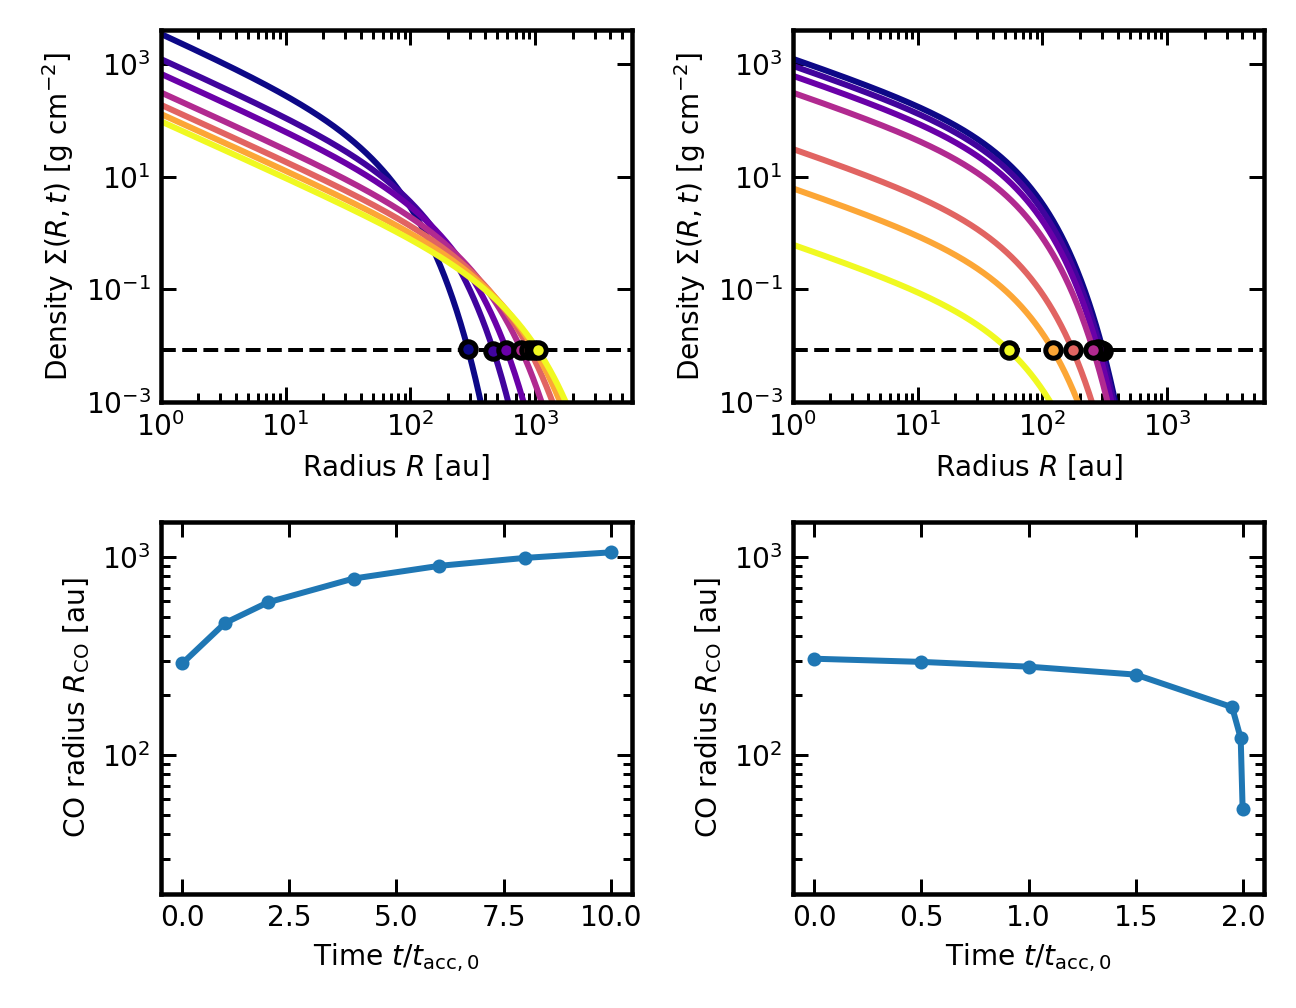

In [9]:
fig, axs = plt.subplots(2,2,figsize=(9,7))

#initialise colormap for plots
cm        = plt.get_cmap('plasma') 
cNorm     = colors.Normalize(vmin=t_visc[0], vmax=t_visc[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

rCO_visc, rCO_wind = [], []
for i in range(len(t_visc)):
    colorVal = scalarMap.to_rgba(t_visc[i])
    
    #from the self-similar density profiles at a given time determine the CO radius
    sigma_visc = f_visc(m0=m0,r0=r0,tacc=tacc,R=R,t=t_visc[i],gm=1.)
    sigma_wind = f_wind(m0=m0,r0=r0,tacc=tacc,R=R,t=t_wind[i],om=1.,lam=3.)*gamma_function(1.25)**2 #gamma function added because of the definition of sigma_wind in Trapman et al. 2022
    rCO_visc.append(R[np.abs(sigma_visc-sigma_cut).argmin()])
    rCO_wind.append(R[np.abs(sigma_wind-sigma_cut).argmin()])
    
    #plot the self-similar density profiles and the intersection with the photodissociation threshold
    axs[0,0].loglog(R, sigma_visc, lw=3., color=colorVal)
    axs[0,0].scatter(rCO_visc[-1], np.interp(rCO_visc[-1],R,sigma_visc), lw=2.5, marker='o', edgecolors='k', zorder=5., s=60., color=colorVal)
    axs[0,1].loglog(R, sigma_wind, lw=3., color=colorVal)
    axs[0,1].scatter(rCO_wind[-1], np.interp(rCO_wind[-1],R,sigma_wind), lw=2.5, marker='o', edgecolors='k', zorder=5., s=60., color=colorVal)

for i in range(2):
    axs[0,i].plot(R, sigma_cut*R/R, ls='--', lw=2.0, c='k')
    axs[0,i].set_xlim(1,6e3)
    axs[0,i].set_xlabel('Radius $R$ [au]')    
    axs[0,i].set_ylim(1e-3,4e3)
    axs[0,i].set_ylabel('Density $\Sigma(R,t)$ [g cm$^{-2}$]')

axs[1,0].semilogy(t_visc/1e6,rCO_visc,lw=3,marker='o')
axs[1,1].semilogy(t_wind/1e6,rCO_wind,lw=3,marker='o')

for i in range(2):
    axs[1,i].set_xlabel(r'Time $t/t_{\rm acc,0}$')
    axs[1,i].set_ylim(2e1,1.5e3)
    axs[1,i].set_ylabel('CO radius $R_\mathrm{CO}$ [au]')

axs[1,0].set_xlim(-0.5,10.5)
axs[1,1].set_xlim(-0.1,2.1)

fig.tight_layout()
plt.show()

Init CO temperature profile (subsequently chosen values are from comparison with the results of Law et al., 2021, 2022a, b):

In [10]:
def f_temp(R,t0,r0,q,T_floor=7.):
    """ 
    Disc temperature as radial power-law. 
    Parameters:
    t0:      reference temperature [K]
    r0:      reference radius [au]
    q:       decay exponent
    T_floor: floor (ISM) temperature [K]
    --------------------------------
    R:       cylindrical radius [au]
    --------------------------------
    Returns the temperature profile [K]
    """
    T = t0*(R/r0)**-q
    
    return (T**4 + T_floor**4)**0.25

<IPython.core.display.Javascript object>


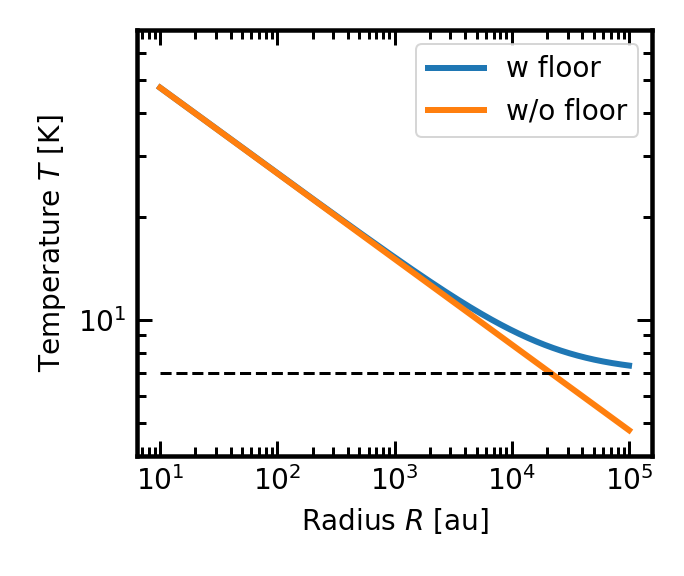

In [11]:
fig, axs = plt.subplots(figsize=(4.75,4))

rad_grid = np.linspace(10,1e5,1000)

axs.loglog(rad_grid,f_temp(rad_grid,40,20,0.25),lw=3.,label='w floor')
axs.loglog(rad_grid,40.*(rad_grid/20.)**(-0.25),lw=3.,label='w/o floor')

axs.plot(rad_grid,7*np.ones(len(rad_grid)),ls='--',c='k')

axs.set_ylim(4,70)
axs.set_xlabel('Radius $R$ [au]')
axs.set_ylabel('Temperature $T$ [K]')
axs.legend()

fig.tight_layout()
plt.show()

Test integrand shape and normalisation:

<IPython.core.display.Javascript object>


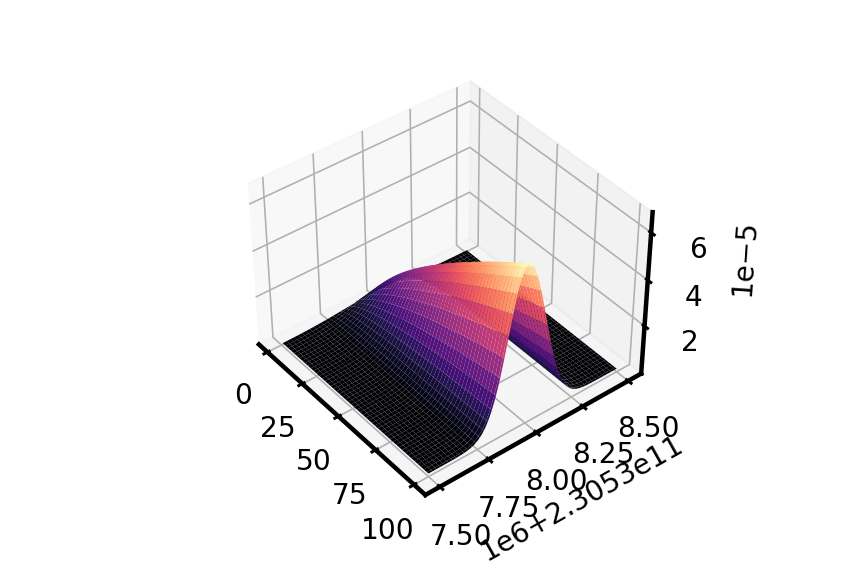

In [12]:
def test_BB(temp,freq_0=freq_0_lupo):
    """ 
    Black body spectrum in mJy/sr.
    Parameters:
    temp:   temperature [K] 
    freq_0: reference frequency [Hz]
    """
    return 2.*h*freq_0**3*c_vel**-2/(np.exp(h*freq_0/(k_B*temp)) - 1.)*1e26 #mJy/sr
    
def test_integrand(rad, freq, temp_args, cos_i=1., dist=150.*pc, freq_0=freq_0_lupo):
    """ 
    Integrand.
    Parameters:
    temp_args:
        t0: reference temperature at r0 [K]
        r0: reference radius [au]
        q:  decay exponent
    cos_i:  cosine of source inclination
    dist:   source distance [au]
    freq_0: reference frequency [Hz]
    --------------------------------
    rad:    cylindrical radius [au]
    freq:   frequency domain [Hz]
    --------------------------------
    Returns the integrand in units that give the total flux in mJy km/s
    """
    temp = f_temp(rad,*temp_args)
    
    bb   = test_BB(temp=temp,freq_0=freq_0)
    
    norm = np.exp(-mass_CO*c_vel**2*(freq - freq_0)**2/(2.*k_B*temp*freq_0**2))
    
    return cos_i/dist**2*bb*norm*2.*np.pi*rad*c_vel/freq_0*1e-5 #mJy*km/s

rad  = np.linspace(1e0,1e2,100)

freq = np.linspace(freq_0_lupo - 5e5, freq_0_lupo + 5e5, 100)

x, y = np.meshgrid(rad, freq)
z = test_integrand(rad=x, freq=y, temp_args=[80,20,0.25])

fig, axs = plt.subplots(subplot_kw={"projection": "3d"})

surf = axs.plot_surface(x,y,z,cmap='magma')

plt.show()

Init `disc` object as class. This class determines the disc surface density profile at a given time, computes the CO radius and flux, and, if required, plots the results. Outputs are given as a `res` dict with relevant information and an `axs` object to customise plots.

In [13]:
class disc(object):
    
    def __init__(self, pars, **kwargs):
        """ Initialises the disc object from a dictionary of parameters. """
        
        self.pars = pars
        
        self.R    = self.grid(
            rin   = self.pars['grid']['rin'], 
            rout  = self.pars['grid']['rout'], 
            nr    = self.pars['grid']['nr'], 
            gtype = self.pars['grid']['gtype']
        )
        
        if self.pars['model'] == 'visc':
            self._call = f_visc
        elif self.pars['model'] == 'MHDwind':
            self._call = f_wind
        else:
            print('Model not initialised (yet!): either "visc" or "MHDwind".')
        
        self._columnCO = self.pars['columnCO']  #self-shielding CO column density
        self._xi       = self.pars['xi']        #CO-to-H2 abundance
        
        self.sigma_cut = self._columnCO/self._xi * 2 * mprot #self-shielding surface density in g/cm2
    
        self.freq_0    = self.pars['freq_0']    #reference frequency in Hz
        self.dist      = self.pars['dist'] * pc #au
        
        self.cos_i     = self.pars['cos_i']     #cos of disc inclination
    
    @staticmethod
    def grid(rin, rout, nr, gtype='log'):
        """
        Computes the radial grid.
        Parameters:
        Rin:   inner radius [au]
        Rout:  outer radius [au]
        nR:    number of radial bins
        gtype: 'linear' or 'log' scale grid
        --------------------------------
        Returns the radial grid [au].
        """
        if gtype == 'log':
            R = np.logspace(rin, rout, nr)
        elif gtype == 'linear':
            R = np.linspace(rin, rout, nr)
            
        return R
    
    def rCO(self, sigma):#, temp_args, freezeout=False):
        """ Computes the CO radius from a model surface density. """
        
        #if not freezeout:
        rad = self.R[np.abs(sigma - self.sigma_cut).argmin()]
        #else:
        #    temp = f_temp(self.R, *temp_args)
        #    
        #    thresh = np.hstack((self.sigma_cut*np.ones(len(self.R))[temp>=19],
        #                        1e2*self.sigma_cut**np.ones(len(self.R))[temp<19]))
        #    
        #    rad = self.R[np.abs(sigma - thresh).argmin()]
            
        return rad
    
    def BB(self, temp):
        """ Black body spectrum in mJy/sr. """
        
        return 2.*h*self.freq_0**3*c_vel**-2/(np.exp(h*self.freq_0/(k_B*temp)) - 1.) * 1e26 #mJy/sr
    
    def integrand(self, freq, rad, temp_args):
        """ 
        Integrand.
        Parameters:
        temp_args:
            t0: reference temperature at r0 [K]
            r0: reference radius [au]
            q:  decay exponent
        --------------------------------
        rad:    cylindrical radius [au]
        freq:   frequency domain [Hz]
        --------------------------------
        Returns the integrand in units that give the total flux in mJy km/s
        """
        temp = f_temp(rad,*temp_args)
        
        bb   = self.BB(temp)
        
        norm = np.exp(-mass_CO*c_vel**2*(freq - self.freq_0)**2/(2.*k_B*temp*self.freq_0**2))
        
        return self.cos_i/self.dist**2*bb*norm*2.*np.pi*rad*c_vel/self.freq_0*1e-5 #mJy*km/s
    
    def compute(self, init_time, sigma_args, temp_args, plot=False, **kwargs): #, freezeout=False, **kwargs):
        """ Returns the surface density, CO radius and CO flux for a set of initial disc parameters at time init_time [yr]. """
        
        fm  = kwargs.get('fm', 1.8)
        
        #init surface density
        sigma = self._call(self.R, init_time, *sigma_args)
        
        #compute CO radius
        rCO   = self.rCO(sigma)#, temp_args, freezeout)
        
        #compute CO flux
        fCO   = integrate.nquad(
            func   = self.integrand, 
            ranges = [[self.freq_0 - 5e5, self.freq_0 + 5e5], [1e-2, rCO]], 
            args   = (temp_args,)
        )[0]
 
        #save results in dict
        res = {
            'R'        : self.R,
            't'        : init_time,
            'sigma'    : sigma,
            'temp'     : f_temp(self.R,*temp_args),
            'cut'      : self.sigma_cut,
            #'freezeout': freezeout,
            'rCO'      : rCO,
            'fCO'      : fCO,
            'm0'       : sigma_args[0],
            'r0'       : sigma_args[1],
            'tacc'     : sigma_args[2],
        }
        
        if self.pars['model'] == 'MHDwind': 
            mt = fmdisc_wind(
                t    = init_time, 
                tacc = sigma_args[2], 
                m0   = sigma_args[0], 
                om   = sigma_args[3],
            )
            
            mdot = fmdot_wind(
                t    = init_time, 
                tacc = sigma_args[2], 
                m0   = sigma_args[0], 
                fm   = fm, 
                om   = sigma_args[3],
            )
            
            res.update({'rout': sigma_args[1], 'mout': mt, 'mdot':mdot, 'om': sigma_args[3], 'lam': sigma_args[4], 'fm':fm})
        
        else:
            mt = fmdisc_visc(
                t    = init_time, 
                tacc = sigma_args[2], 
                m0   = sigma_args[0], 
                gm   = sigma_args[3],
            )
            
            rt = frout_visc(
                t    = init_time, 
                tacc = sigma_args[2], 
                r0   = sigma_args[1], 
                gm   = sigma_args[3],
            )
            
            mdot = fmdot_visc(
                t    = init_time, 
                tacc = sigma_args[2], 
                m0   = sigma_args[0], 
                gm   = sigma_args[3],
            )
        
            res.update({'rout': rt, 'mout': mt, 'mdot':mdot, 'gm': sigma_args[3]})
        
        #plot final results
        if plot:
            axs = self.plot(res=[res], times=np.array([init_time]), scatter = True)
        
            return res, axs
        else:
            return res
    
    def plot(self, res, **kwargs):
        """ Plots surface density, CO radius and CO flux for a set of initial disc parameters. """
        
        fig   = kwargs.get('fig', None)
                
        if not fig:
            fig, axs = plt.subplots(1,3,figsize=(13.5,4))
        else:
            axs = fig.get_axes()
            
        times = kwargs.get('times', [])
        if len(times) == 0.:
            times = res['times']
            
        scatter = kwargs.get('scatter', False)
        
        cm        = plt.get_cmap('plasma') 
        cNorm     = colors.Normalize(vmin=times[0], vmax=times[-1])
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
        
        radius, flux = [], []
        for i in range(len(times)): 
            colorVal = scalarMap.to_rgba(times[i])
            
            axs[0].loglog(res[i]['R'], res[i]['sigma'], color=colorVal, lw=3.)
            axs[0].scatter(res[i]['rCO'], np.interp(res[i]['rCO'],res[i]['R'],res[i]['sigma']), color=colorVal, s=50., lw=2., edgecolors='k', zorder=10.)
            
            radius.append(res[i]['rCO'])
            flux.append(res[i]['fCO'])
        
        #if not res[0]['freezeout']:
        axs[0].plot(self.R,res[0]['cut']*res[0]['R']/res[0]['R'],c='k',ls='--',lw=2.)  
        #else:
        #    thresh = np.hstack((self.sigma_cut*np.ones(len(self.R))[res[0]['temp']>=19],
        #                        1e2*self.sigma_cut**np.ones(len(self.R))[res[0]['temp']<19]))
        #    
        #    axs[0].plot(self.R,thresh,c='k',ls='--',lw=2.)
        #    ays = axs[0].twinx()
        #    ays.plot(self.R,res[0]['temp'],c='k',ls='--',lw=2.)
        #    
        #    t19 = self.R[np.where(np.abs(res[0]['temp'] - 19.) == np.amin(np.abs(res[0]['temp'] - 19.)))][0]
        #    ays.scatter(t19,np.interp(t19,self.R,res[0]['temp']),c='k')
        #    ays.set_ylim(0,100)
                        
        axs[1].plot(times/1e6, radius, c='C0', lw=3.)
        axs[2].plot(times/1e6, flux, c='C0', lw=3.)
        if scatter:
            axs[1].scatter(times/1e6, radius, c='C0', s=50.)
            axs[2].scatter(times/1e6, flux, c='C0', s=50.)
        
        axs[0].set_xlabel('Radius $R$ [au]')
        axs[0].set_ylabel('Density $\Sigma(R,t)$ [g cm$^{-2}$]')
        axs[0].set_xlim(1,6e2)
        axs[0].set_ylim(4e-3,5e2)
        
        axs[1].set_xlabel('Time $t$ [Myr]')
        axs[1].set_ylabel('CO radius $R_\mathrm{CO}$ [au]')
        if len(times) > 1:
            axs[1].set_xlim(times[0]/1e6,times[-1]/1e6)
        elif times == [0.]:
            axs[1].set_xlim(-0.2,0.2)
        else:
            axs[1].set_xlim(times[0]/1e6/2.,3.*times[0]/1e6/2.)
        
        axs[2].set_xlabel('Time $t$ [Myr]')
        axs[2].set_ylabel('CO flux $F_\mathrm{CO}$ [mJy km s$^{-1}$]') 
        if len(times) > 1:
            axs[2].set_xlim(times[0]/1e6,times[-1]/1e6)
        elif times == [0.]:
            axs[2].set_xlim(-0.2,0.2)
        else:
            axs[2].set_xlim(times[0]/1e6/2.,3.*times[0]/1e6/2.)
        
        fig.tight_layout()
        return fig, axs

In [14]:
def run_evol(obj,times,sigma_args,temp_args,fm=1.8): #,freezeout=False):
    """ 
    Wrapper of `disc` that works for a sequence of times. 
    Parameters:
    obj:        disc object `disc(pars)` for some parameters
    times:      array of evolution times [yr]
    sigma_args: [m0,r0,tacc,gm or om,lam]
    temp_args:  [tc,rc,q]
    freezeout:  if freeze-out is considered to compute the CO radius.
    --------------------------------
    Returns a dict of all result dicts
    """
    res_all = dict()
    res_all.update({'times':times})
    
    for i in range(len(times)):
        
        res_all[i] = obj.compute(init_time=times[i], sigma_args=sigma_args, temp_args=temp_args, fm=fm) #, freezeout=freezeout)
            
    return res_all

Recover the previous results (benchmarking these models against Figure 2 of Trapman et al., 2022):

<IPython.core.display.Javascript object>


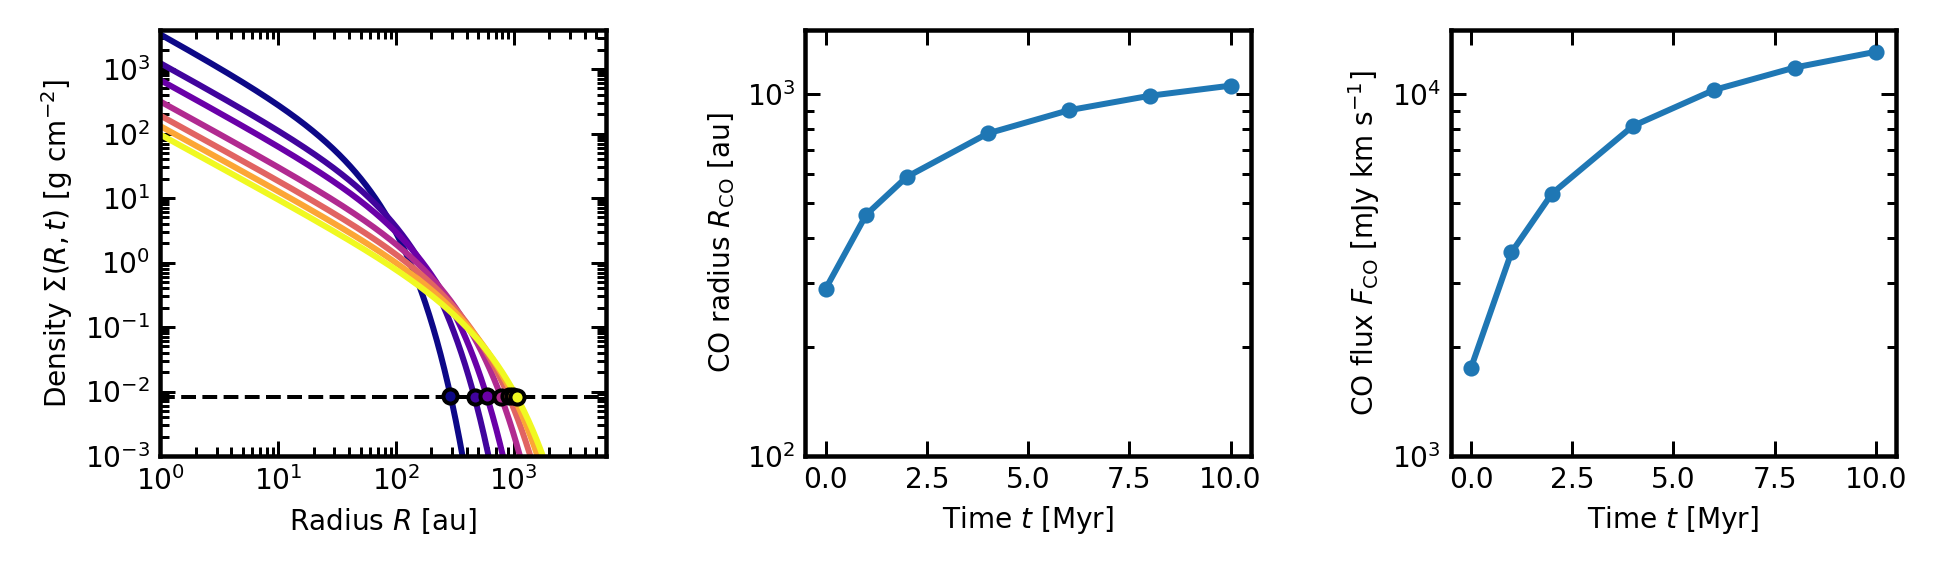

In [15]:
pars = {
    'grid': {
        'rin'  : 0.,
        'rout' : 4.,
        'nr'   : 1000,
        'gtype': 'log',
    },
    'model'    : 'visc',
    'xi'       : 1e-4,
    'columnCO' : 2.5e17,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.,
    'cos_i'    : 1.
}

visc = disc(pars)

res_all = run_evol(
    obj        = visc,
    times      = np.array([0,1,2,4,6,8,10])*1e6,
    sigma_args = [1e-1,40,1e6,1],
    temp_args  = [40,20,0.25],
)

_, axs = visc.plot(res = res_all, scatter = True)

axs[0].set_xlim(1,6e3)
axs[0].set_ylim(1e-3,4e3)

axs[1].set_yscale('log')
axs[1].set_xlim(-0.5,10.5)
axs[1].set_ylim(1e2,1.5e3)

axs[2].set_yscale('log')
axs[2].set_xlim(-0.5,10.5)
axs[2].set_ylim(1e3,1.5e4)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


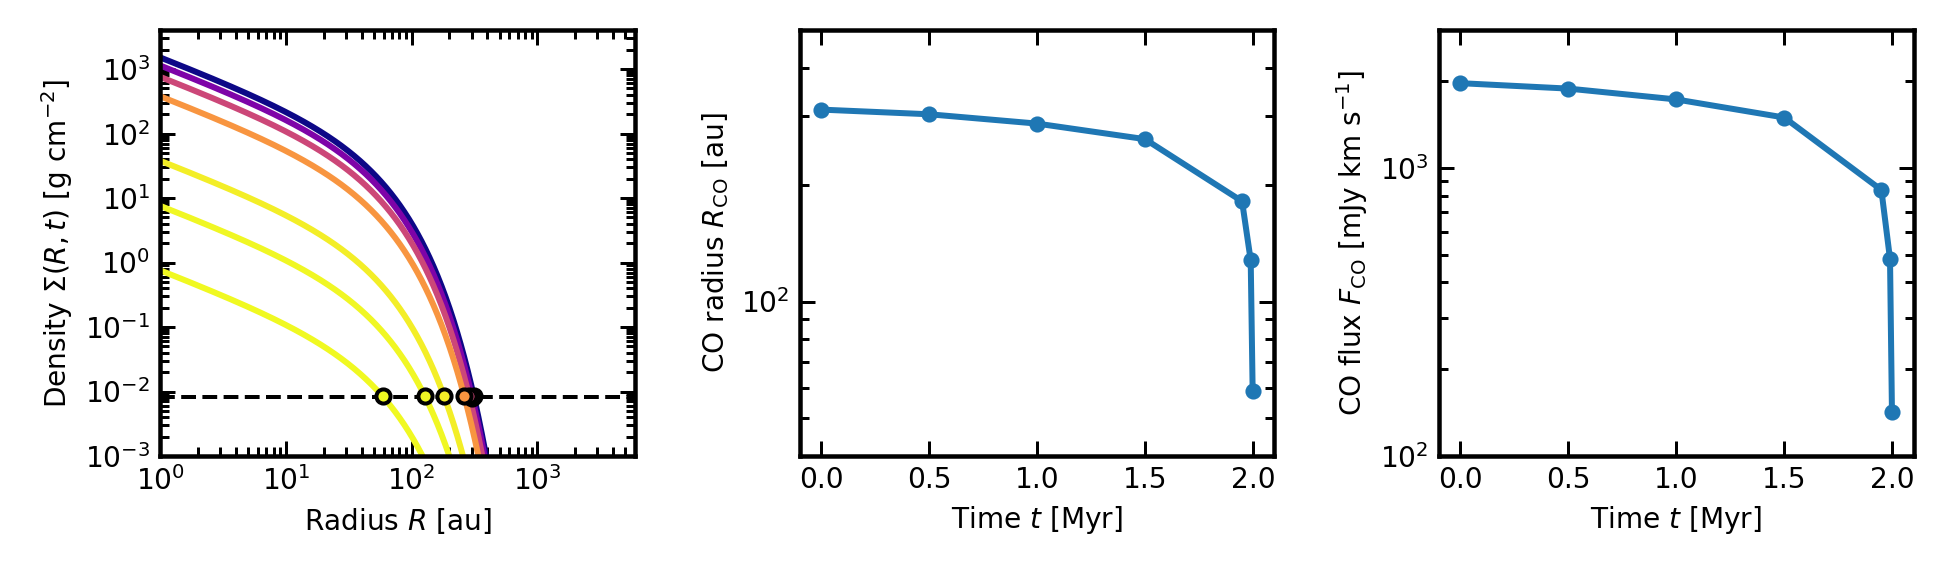

In [16]:
pars = {
    'grid': {
        'rin'  : 0.,
        'rout' : 4.,
        'nr'   : 1000,
        'gtype': 'log',
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 2.5e17,#/gamma_function(1.25)**2,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.,
    'cos_i'    : 1.,
}

wind = disc(pars)

res_all = run_evol(
    obj        = wind,
    times      = np.array([0,0.5,1,1.5,1.95,1.99,1.999])*1e6,
    sigma_args = [1e-1,40,1e6,1,3],
    temp_args  = [40,20,0.25], 
)

_, axs = wind.plot(res = res_all, scatter = True)

axs[0].set_xlim(1,6e3)
axs[0].set_ylim(1e-3,4e3)

axs[1].set_yscale('log')
axs[1].set_xlim(-0.1,2.1)
axs[1].set_ylim(4e1,5e2)

axs[2].set_yscale('log')
axs[2].set_xlim(-0.1,2.1)
axs[2].set_ylim(1e2,3e3)

fig.tight_layout()
plt.show()

## Benchmarking

In [17]:
interval   = np.linspace(-1.,3.,5)
cmi        = plt.get_cmap('plasma') 
ciNorm     = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMapi = cmx.ScalarMappable(norm=ciNorm, cmap=cmi)

Choose temperature profile (by comparison with Law et al., 2021, 2022a, b papers):

In [18]:
rin,rout,temp,q = np.loadtxt('./tables/temp.dat',skiprows=1,unpack=True,usecols=(1,2,3,5))
names = ['IMLup','GMAur','AS209','MYLup','GWLup','WaOph6','DoAr25','Sz91','CITau','DMTau','LkCa15']

<IPython.core.display.Javascript object>


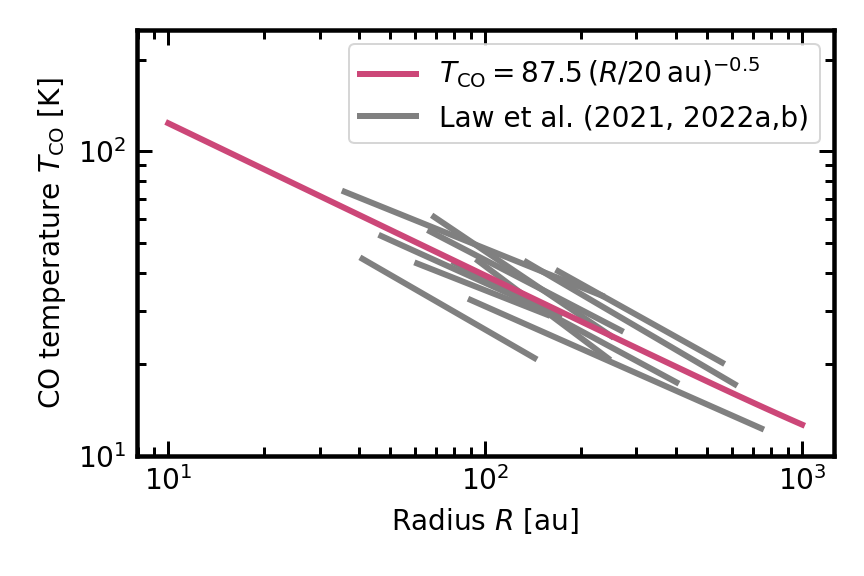

In [19]:
fig, axs = plt.subplots()

rad   = np.linspace(10,1000,100)
ptemp = f_temp(rad,87.5,20,0.50,7.)

axs.loglog(rad,ptemp,lw=3.,label=r'$T_{\rm CO} = 87.5\,(R/20\,{\rm au})^{-0.5}$',zorder=10,c=scalarMapi.to_rgba(interval[2]))

for idx in range(len(temp)):
    rad = np.linspace(rin[idx],rout[idx],100)
    if idx == 0:
        axs.plot(rad,temp[idx]*(rad/100.)**-q[idx],lw=3,label="Law et al. (2021, 2022a,b)",zorder=0,c='gray')
    else:
        axs.plot(rad,temp[idx]*(rad/100.)**-q[idx],lw=3,zorder=0,c='gray')
        
axs.set_xlabel(r'Radius $R$ [au]')
axs.set_ylabel(r'CO temperature $T_{\rm CO}$ [K]')

axs.legend()

axs.set_ylim(10,250)

fig.tight_layout()

#plt.savefig('./paper_plots/temp_comparison.pdf',bbox_inches='tight')
plt.show()

Benchmark semi-analytical fluxes against the full radiative-transfer DALI simulations of Miotello et al. (2016). In this case the temperature is chosen to be more consistent with these models. The model outputs are available at CDS at this link: https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/594/A85

Trapman et al. (2019) suggested that it is OK to assume that `J=2-1` and `J=3-2` transitions have the same CO radius and a photodissociation column density of `1e15`. We will use `5e15` to take into account freeze-out, chemical evolution and non-homogenous vertically averaged CO column density.

In [20]:
fact = np.pi/(4.*np.log(2.))*(np.pi/(180*3600))**2*2*1e18*k_B/c_vel**2*1e23
print(fact)

8.182500235029555e-07


In [21]:
def Tb_to_Jy(data, freq, beam):
    """ 
    Converts flux from [K] to [mJy] using Rayleigh-Jeans approximation. 
    Check Bruderer et al. (2013), Appendix B Eq. B3.
    Parameters:
    freq: frequency [Hz],
    beam: beam maj, min assumed equal [arcsec],
    data: brightness temperature [K km/s],
    --------------------------------
    Return flux in [mJy km/s].
    """
    fact = np.pi/(4.*np.log(2.))*(np.pi/(180*3600))**2*2*1e18*k_B/c_vel**2*1e26
    
    return fact*(freq*1e-9)**2*(beam)**2*data #mJy km/s

In [22]:
rc,gamma,hc,psi,mdisk,_12COJ2_1inc10,_12COJ2_1inc80,_12COJ3_2inc10,_12COJ3_2inc80 = np.loadtxt(
    './tables/tablea4.dat',skiprows=6,unpack=True,delimiter='|',usecols=(0,1,2,3,4,9,10,11,12))

In [23]:
print(rc[0],gamma[0],hc[0],psi[0],mdisk[0],_12COJ2_1inc10[0],_12COJ2_1inc80[0],_12COJ3_2inc10[0],_12COJ3_2inc80[0])

30.0 0.8 0.1 0.1 1e-05 0.39925 0.21707 0.4039 0.21001


<IPython.core.display.Javascript object>


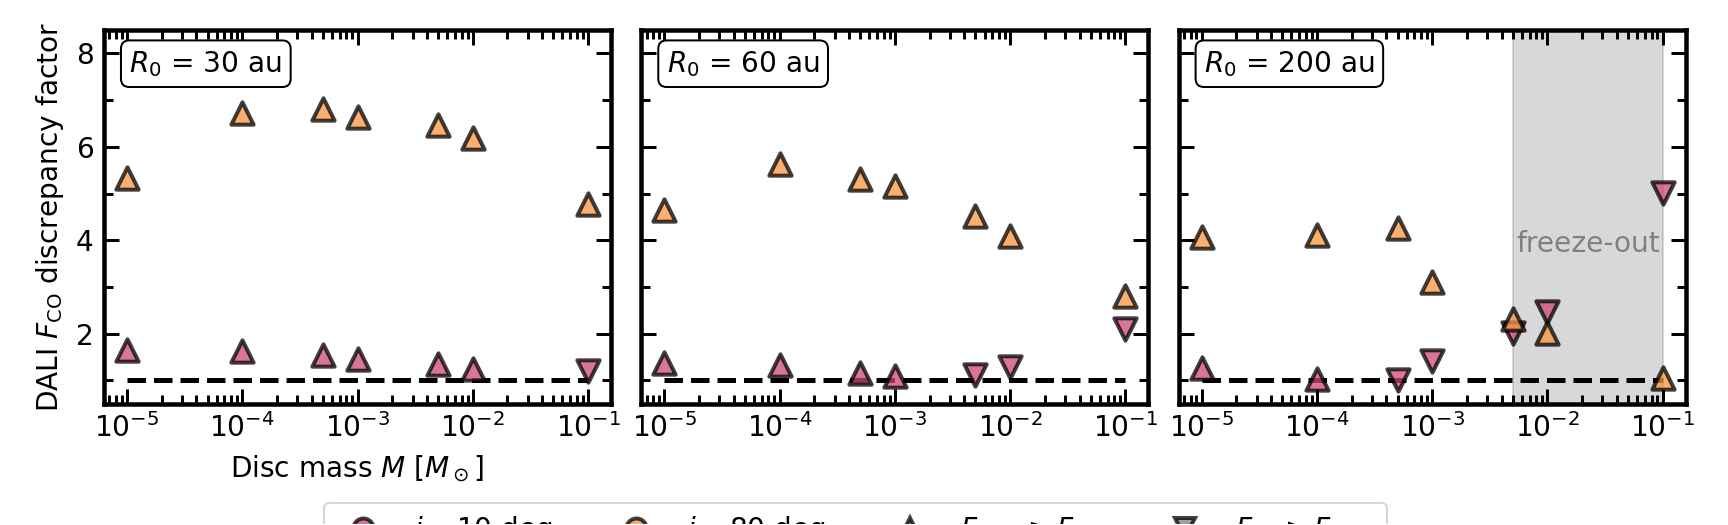

In [24]:
color = [scalarMapi.to_rgba(interval[2]),scalarMapi.to_rgba(interval[3])]
inc   = [10.,80.]

fig, axs = plt.subplots(1,3,figsize=(12.,3.65),sharex='all',sharey='all')

for i,_rc in enumerate(np.unique(rc)):
    
    for _mdisk in np.unique(mdisk):
        
        for j,_inc in enumerate(np.unique(inc)):
            
            pars = {
                'grid': {
                    'rin'  : 0.,
                    'rout' : 4.,
                    'nr'   : 1000,
                    'gtype': 'log'
                },
                'model'    : 'visc',
                'xi'       : 1e-4,
                'columnCO' : 5e15,
                'freq_0'   : freq_0_lupo,
                'dist'     : 100.,        #Miotello et al. 2016, table A.4
                'cos_i'    : np.cos(_inc*np.pi/180.),
            }
            
            visc = disc(pars)

            res  = visc.compute(init_time=0., sigma_args=[_mdisk,_rc,1,1.5], temp_args=[40.,20.,0.25])
            
            mask = np.logical_and(gamma == 1.5, np.logical_and(rc == _rc, mdisk == _mdisk))
            
            if _inc == 10.:
                ff = Tb_to_Jy(data = np.mean(_12COJ2_1inc10[mask]), freq = freq_0_lupo, beam = 10.)/res['fCO'] #10" beam from Miotello et al. 2016, table A.4
            elif _inc == 80.:
                ff = Tb_to_Jy(data = np.mean(_12COJ2_1inc80[mask]), freq = freq_0_lupo, beam = 10.)/res['fCO'] #10" beam from Miotello et al. 2016, table A.4
                
            if ff < 1.:
                axs[i].scatter(_mdisk, ff**-1, color=color[j], marker='v', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
            else:
                axs[i].scatter(_mdisk, ff,     color=color[j], marker='^', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
    
    axs[i].plot([1e-5,1e-1], [1,1], ls='--', c='k', lw=2.5)
    axs[i].text(0.05, 0.95, r'$R_0$ = {} au'.format(int(_rc)), ha='left', va='top', transform=axs[i].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    axs[i].yaxis.set_minor_locator(MultipleLocator(1))
    
axs[0].set_xscale('log')
axs[0].set_ylim(0.5,8.5)
    
axs[0].set_xlabel(r'Disc mass $M$ [$M_\odot$]')
axs[0].set_ylabel(r'DALI $F_{\rm CO}$ discrepancy factor')

axs[2].fill_betweenx(y=[0.5,9.5],x1=5e-3,x2=1e-1,color='gray',alpha=0.3)
axs[2].text(5.35e-3,3.75,'freeze-out',color='gray',zorder=-5)

legend_elements = [
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[2]), marker='o', label=r'$i=10$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[3]), marker='o', label=r'$i=80$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='^', label=r'$F_{\rm DALI}\geq F_{\rm 1D}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='v', label=r'$F_{\rm 1D}>F_{\rm DALI}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
        ]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.495,-0.09))
    
fig.tight_layout()
#plt.savefig('./paper_plots/comparison_CO2-1.pdf',bbox_inches='tight')

plt.show()

<IPython.core.display.Javascript object>


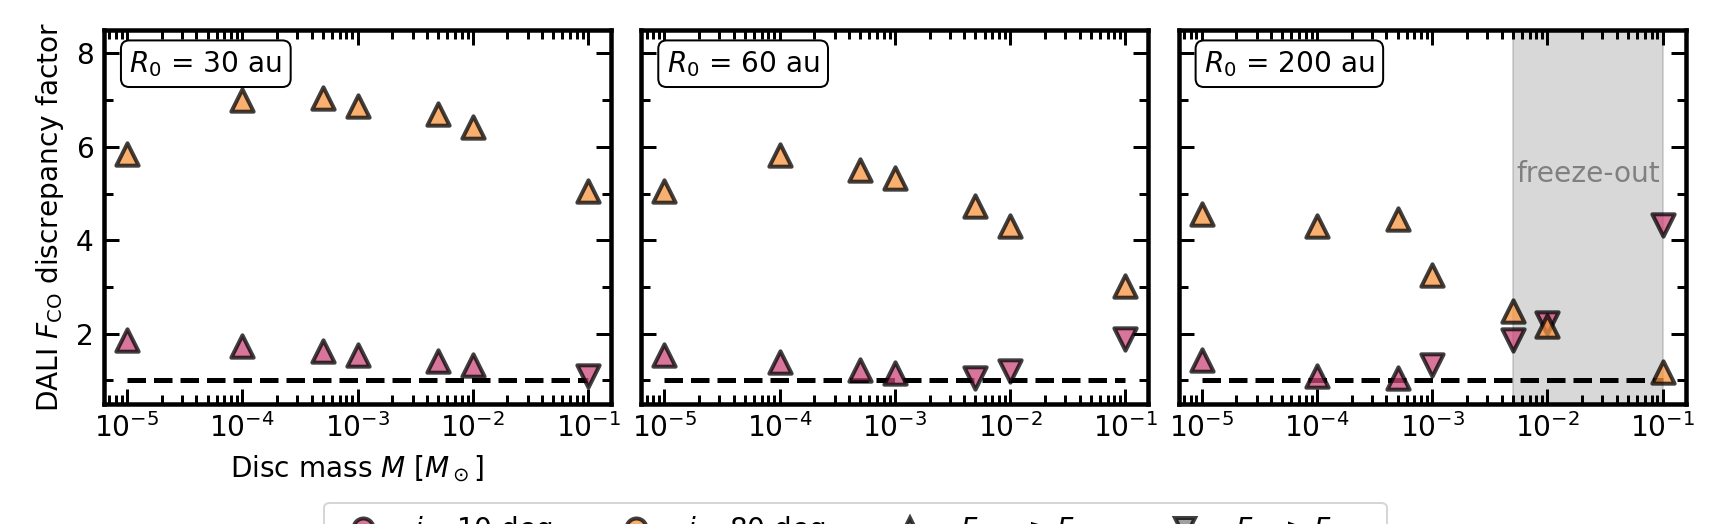

In [25]:
color = [scalarMapi.to_rgba(interval[2]),scalarMapi.to_rgba(interval[3])]
inc   = [10.,80.]

fig, axs = plt.subplots(1,3,figsize=(12.,3.65),sharex='all',sharey='all')

for i,_rc in enumerate(np.unique(rc)):
    
    for _mdisk in np.unique(mdisk):
        
        for j,_inc in enumerate(np.unique(inc)):
            
            pars = {
                'grid': {
                    'rin'  : 0.,
                    'rout' : 4.,
                    'nr'   : 1000,
                    'gtype': 'log'
                },
                'model'    : 'visc',
                'xi'       : 1e-4,
                'columnCO' : 5e15,
                'freq_0'   : freq_0_usco,
                'dist'     : 100.,        #Miotello et al. 2016, table A.4
                'cos_i'    : np.cos(_inc*np.pi/180.),
            }
            
            visc = disc(pars)

            res  = visc.compute(init_time=0., sigma_args=[_mdisk,_rc,1,1.5], temp_args=[40.,20.,0.25])
            
            mask = np.logical_and(gamma == 1.5, np.logical_and(rc == _rc, mdisk == _mdisk))
            
            if _inc == 10.:
                ff = Tb_to_Jy(data = np.mean(_12COJ3_2inc10[mask]), freq = freq_0_usco, beam = 10.)/res['fCO'] #10" beam from Miotello et al. 2016, table A.4
            elif _inc == 80.:
                ff = Tb_to_Jy(data = np.mean(_12COJ3_2inc80[mask]), freq = freq_0_usco, beam = 10.)/res['fCO'] #10" beam from Miotello et al. 2016, table A.4
                
            if ff < 1.:
                axs[i].scatter(_mdisk, ff**-1, color=color[j], marker='v', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
            else:
                axs[i].scatter(_mdisk, ff,     color=color[j], marker='^', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
    
    axs[i].plot([1e-5,1e-1], [1,1], ls='--', c='k', lw=2.5)
    axs[i].text(0.05, 0.95, r'$R_0$ = {} au'.format(int(_rc)), ha='left', va='top', transform=axs[i].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    axs[i].yaxis.set_minor_locator(MultipleLocator(1))
    
axs[0].set_xscale('log')
axs[0].set_ylim(0.5,8.5)
    
axs[0].set_xlabel(r'Disc mass $M$ [$M_\odot$]')
axs[0].set_ylabel(r'DALI $F_{\rm CO}$ discrepancy factor')

axs[2].fill_betweenx(y=[0.5,9.5],x1=5e-3,x2=1e-1,color='gray',alpha=0.3)
axs[2].text(5.35e-3,5.25,'freeze-out',color='gray',zorder=-5)

legend_elements = [
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[2]), marker='o', label=r'$i=10$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[3]), marker='o', label=r'$i=80$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='^', label=r'$F_{\rm DALI}\geq F_{\rm 1D}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='v', label=r'$F_{\rm 1D}>F_{\rm DALI}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
        ]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.495,-0.09))
    
fig.tight_layout()
#plt.savefig('./paper_plots/comparison_CO3-2.pdf',bbox_inches='tight')

plt.show()

Show that the conversion using RJ approximation from `J=3-2` to `J=2-1` in your models does not affect the comparison:

<IPython.core.display.Javascript object>


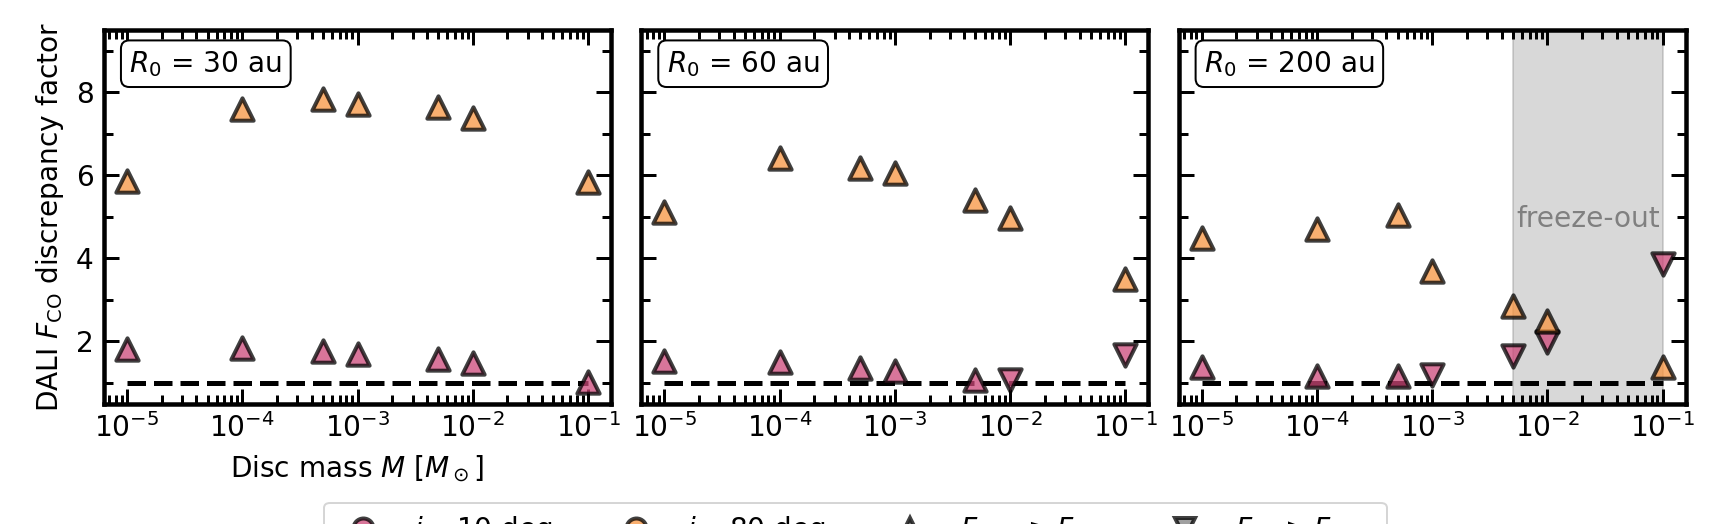

In [26]:
color = [scalarMapi.to_rgba(interval[2]),scalarMapi.to_rgba(interval[3])]
inc   = [10.,80.]

fig, axs = plt.subplots(1,3,figsize=(12.,3.65),sharex='all',sharey='all')

for i,_rc in enumerate(np.unique(rc)):
    
    for _mdisk in np.unique(mdisk):
        
        for j,_inc in enumerate(np.unique(inc)):
            
            pars = {
                'grid': {
                    'rin'  : 0.,
                    'rout' : 4.,
                    'nr'   : 1000,
                    'gtype': 'log'
                },
                'model'    : 'visc',
                'xi'       : 1e-4,
                'columnCO' : 5e15,
                'freq_0'   : freq_0_usco,
                'dist'     : 100.,        #Miotello et al. 2016, table A.4
                'cos_i'    : np.cos(_inc*np.pi/180.),
            }
            
            visc = disc(pars)

            res  = visc.compute(init_time=0., sigma_args=[_mdisk,_rc,1,1.5], temp_args=[40.,20.,0.25])
            
            mask = np.logical_and(gamma == 1.5, np.logical_and(rc == _rc, mdisk == _mdisk))
            
            if _inc == 10.:
                ff = Tb_to_Jy(data = np.mean(_12COJ2_1inc10[mask]), freq = freq_0_lupo, beam = 10.)/(res['fCO']*(freq_0_lupo/freq_0_usco)**2) #10" beam from Miotello et al. 2016, table A.4
            elif _inc == 80.:
                ff = Tb_to_Jy(data = np.mean(_12COJ2_1inc80[mask]), freq = freq_0_lupo, beam = 10.)/(res['fCO']*(freq_0_lupo/freq_0_usco)**2) #10" beam from Miotello et al. 2016, table A.4
                
            if ff < 1.:
                axs[i].scatter(_mdisk, ff**-1, color=color[j], marker='v', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
            else:
                axs[i].scatter(_mdisk, ff,     color=color[j], marker='^', s=125, alpha=0.75, lw=2., edgecolor='k', zorder=10)
    
    axs[i].plot([1e-5,1e-1], [1,1], ls='--', c='k', lw=2.5)
    axs[i].text(0.05, 0.95, r'$R_0$ = {} au'.format(int(_rc)), ha='left', va='top', transform=axs[i].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    axs[i].yaxis.set_minor_locator(MultipleLocator(1))
    
axs[0].set_xscale('log')
axs[0].set_ylim(0.5,9.5)
    
axs[0].set_xlabel(r'Disc mass $M$ [$M_\odot$]')
axs[0].set_ylabel(r'DALI $F_{\rm CO}$ discrepancy factor')

axs[2].fill_betweenx(y=[0.5,9.5],x1=5e-3,x2=1e-1,color='gray',alpha=0.3)
axs[2].text(5.35e-3,4.75,'freeze-out',color='gray',zorder=-5)

legend_elements = [
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[2]), marker='o', label=r'$i=10$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color=scalarMapi.to_rgba(interval[3]), marker='o', label=r'$i=80$ deg', ms=10, alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='^', label=r'$F_{\rm DALI}\geq F_{\rm 1D}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
    Line2D([0], [0], ls='none', color='k', marker='v', label=r'$F_{\rm 1D}>F_{\rm DALI}$', ms=10, c='gray', alpha=0.75, mew=2., markeredgecolor='k'),
        ]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.495,-0.09))
    
fig.tight_layout()
plt.show()

## Survival function

Plot the survival function for Lupus and Upper Sco data:

In [27]:
interval   = np.linspace(-1.,3.,9)
cmi        = plt.get_cmap('plasma') 
ciNorm     = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMapi = cmx.ScalarMappable(norm=ciNorm, cmap=cmi)

In [28]:
from lifelines import KaplanMeierFitter

def cumulative(fig, axs, alpha_KMF = 0.32, resolved=False, non_det=False):
    """ Plot survival funcation for Lupus and Upper Sco data. """
    
    dist, flup, eflup, trap = np.loadtxt('./tables/lupoCO.dat', unpack=True, skiprows=6, usecols=(2,3,4,7))

    eobs_lup = np.ones(len(flup)) #True if the the death was observed (i.e. detection), False if the event was lost (i.e. non-detection)
    eobs_lup[flup <= 3.*eflup] = 0.
    #print(len(eobs_lup[eobs_lup>0]))
    flup[flup <= 3.*eflup] = 3. * eflup[flup <= 3.*eflup]
    
    flup *= (dist/150.)**2 #scale CO fluxes to 150pc
    
    resol = np.array([x for _,x in sorted(zip(flup,trap))])
    cens  = np.array([x for _,x in sorted(zip(flup,eobs_lup))])
    
    kmf = KaplanMeierFitter(label='Lupus')
    kmf.fit_left_censoring(flup,event_observed=eobs_lup,alpha=alpha_KMF,label='Lupus',timeline=np.sort(flup))
    lup = np.array(kmf.survival_function_['Lupus'])
    tim = np.array(kmf.timeline)
    axs.scatter(tim, lup, zorder=10, alpha=0.3, s=25, color=scalarMapi.to_rgba(interval[3]))
    if non_det:
        axs.scatter(tim[cens==0], lup[cens==0], zorder=10, s=25, color=scalarMapi.to_rgba(interval[3]), lw=1.5, edgecolor='r')
    if resolved:
        axs.scatter(tim[resol>0], lup[resol>0], zorder=10, s=25, color=scalarMapi.to_rgba(interval[3]), lw=1.5, edgecolor='k')
    l, = axs.semilogx(tim, lup, lw=1, ls='--', color=scalarMapi.to_rgba(interval[3]))
    lupm = kmf.confidence_interval_survival_function_['Lupus_lower_0.68']
    lupp = kmf.confidence_interval_survival_function_['Lupus_upper_0.68']
    axs.fill_between(tim, lupm, lupp, alpha=0.3, color=l.get_color())

    dist, fsco, efsco, trap = np.loadtxt('./tables/uscoCO.dat', unpack=True, skiprows=1, usecols=(2,3,4,5))
    
    eobs_sco = np.ones(len(fsco)) #True if the the death was observed, False if the event was lost
    eobs_sco[fsco <= 3.*efsco] = 0.
    #print(len(eobs_sco[eobs_sco>0]))
    fsco[fsco <= 3.*efsco] = 3. * efsco[fsco <= 3.*efsco]

    fsco *= (freq_0_lupo/freq_0_usco)**2*(dist/150.)**2 #scale CO fluxes to 2-1 frequency and 150pc

    resol = np.array([x for _,x in sorted(zip(fsco,trap))])
    cens  = np.array([x for _,x in sorted(zip(fsco,eobs_sco))])
    
    kmf = KaplanMeierFitter(label='Upper Sco')
    kmf.fit_left_censoring(fsco,event_observed=eobs_sco,alpha=alpha_KMF,label='Upper Sco',timeline=np.sort(fsco))
    sco = np.array(kmf.survival_function_['Upper Sco'])
    tim = np.array(kmf.timeline)
    axs.scatter(tim, sco, zorder=10, alpha=0.3, s=25, color=scalarMapi.to_rgba(interval[6]))
    if non_det:
        axs.scatter(tim[cens==0], sco[cens==0], zorder=10, s=25, color=scalarMapi.to_rgba(interval[6]), lw=1.5, edgecolor='r')
    if resolved:
        axs.scatter(tim[resol>0], sco[resol>0], zorder=10, s=25, color=scalarMapi.to_rgba(interval[6]), lw=1.5, edgecolor='k')
    l, = axs.semilogx(tim, sco, lw=1, ls='--', color=scalarMapi.to_rgba(interval[6]))
    scom = kmf.confidence_interval_survival_function_['Upper Sco_lower_0.68']
    scop = kmf.confidence_interval_survival_function_['Upper Sco_upper_0.68']
    axs.fill_between(tim, scom, scop, alpha=0.3, color=l.get_color())

    axs.set_xscale('log')
    axs.set_ylim(-0.1,1.1)
    
    return flup, fsco

<IPython.core.display.Javascript object>


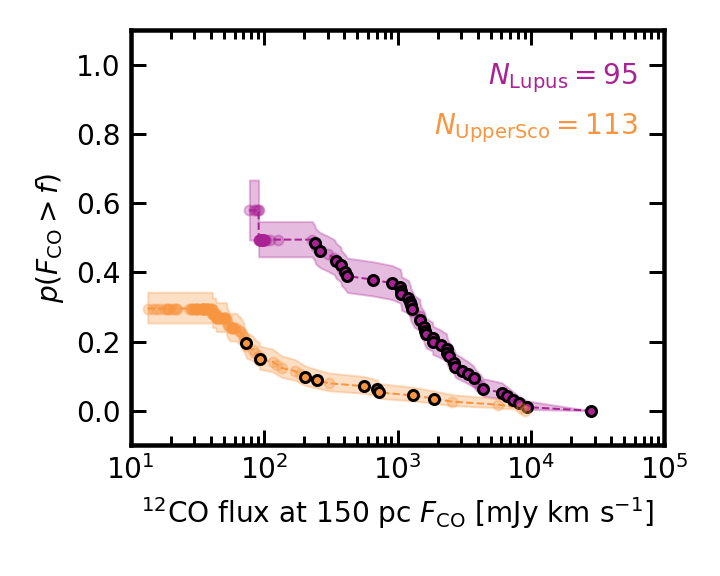

In [29]:
fig, axs = plt.subplots(figsize=(5,4))

cumulative(fig,axs,resolved=True)

axs.set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')
axs.set_ylabel('$p(F_\mathrm{CO}>f)$')

axs.set_xlim(1e1,1e5)

axs.text(0.95, 0.925, r'$N_{\rm Lupus}=95$', ha='right', va='top', 
        transform=axs.transAxes, color=scalarMapi.to_rgba(interval[3]))
axs.text(0.95, 0.805, r'$N_{\rm UpperSco}=113$', ha='right', va='top', 
        transform=axs.transAxes, color=scalarMapi.to_rgba(interval[6]))

fig.tight_layout()
#plt.savefig('./paper_plots/sample_survival.pdf',bbox_inches='tight')

plt.show()

## Pops: viscous models

Init wrapper to run populations of discs:

In [30]:
def run_pop_visc(obj, m0, r0, tacc, t, gm, temp_args, **kwargs):
    """ Wrapper to run populations of discs according to underlying parameter initial distributions.
        Caveat: running nested for-loops is slow and requires thousands of discs to sample the distributions properly. Avoid."""
    
    times, fluxes, sizes, rout, mout, mdot = [], [], [], [], [], []
    for i in range(len(m0)):
        res = obj.compute(init_time = t[i], sigma_args = [m0[i],r0[i],tacc[i],gm], temp_args = temp_args) #, freezeout=False)
        
        times.append(res['t'])
        
        sizes.append(res['rCO'])
        fluxes.append(res['fCO']*(freq_0_lupo/obj.pars['freq_0'])**2) #rescaled frequencies to account for different line transitions
        
        rout.append(res['rout'])
        mout.append(res['mout'])
        mdot.append(res['mdot'])

    out = {
        'times':  np.array(times),
        'fluxes': np.array(fluxes),
        'sizes':  np.array(sizes),
        'rout':   np.array(rout),
        'mout':   np.array(mout),
        'mdot':   np.array(mdot),
    }
    
    return out

In [31]:
def gaussian(x,mean,sigma):
    """ A Gaussian function with prescribed mean (mean) and standard deviation (sigma). """
    return (2*np.pi*sigma**2)**-0.5*np.exp(-0.5*(x - mean)**2/sigma**2)

def f_alpha(tacc,r0,h=0.1,mstar=m_sun,gamma=1.5):
    """
    Computes alpha_SS from the viscous time scale and initial disc radius distribution for a give pressure scale height.
    Parameters:
    tacc:  viscous timescale [yr]
    r0:    initial disc size [au]
    mstar: stellar mass      [m_sun]
    gamma: power-law viscosity exponent
    --------------------------------
    Returns alpha
    """
    return (3*(2-gamma)**2*1e6*year*0.1**2*(10.*au)**-1.5*np.sqrt(grav*m_sun))**-1*(mstar/m_sun)**-0.5*(tacc/1e6)**-1*(h/0.1)**-2*(r0/10.)

Init your population of discs using the initial conditions of Lodato et al. (2017). The effect of radial drift is that these conditions underestimate tacc and m0. R0/alpha are less well constrained. We used the distribution of dust disc radii of Class 0 sources of Sheehan et al. (2022):

In [32]:
seed_in = 125
np.random.seed(seed = seed_in) #fix the seed to make different tests under same parameters (no substantial changes with different seeds)

n_dadi  = 3000
print('Number of discs: {}'.format(n_dadi))

r0   = 10.**np.random.normal( 1.55, 0.4, n_dadi)
tacc = 10.**np.random.normal( 5.8 , 1.0, n_dadi)
time = 10.**np.random.normal( 5.9 , 0.3, n_dadi)
m0   = 10.**np.random.normal(-2.7 , 0.7, n_dadi)

Number of discs: 3000


<IPython.core.display.Javascript object>


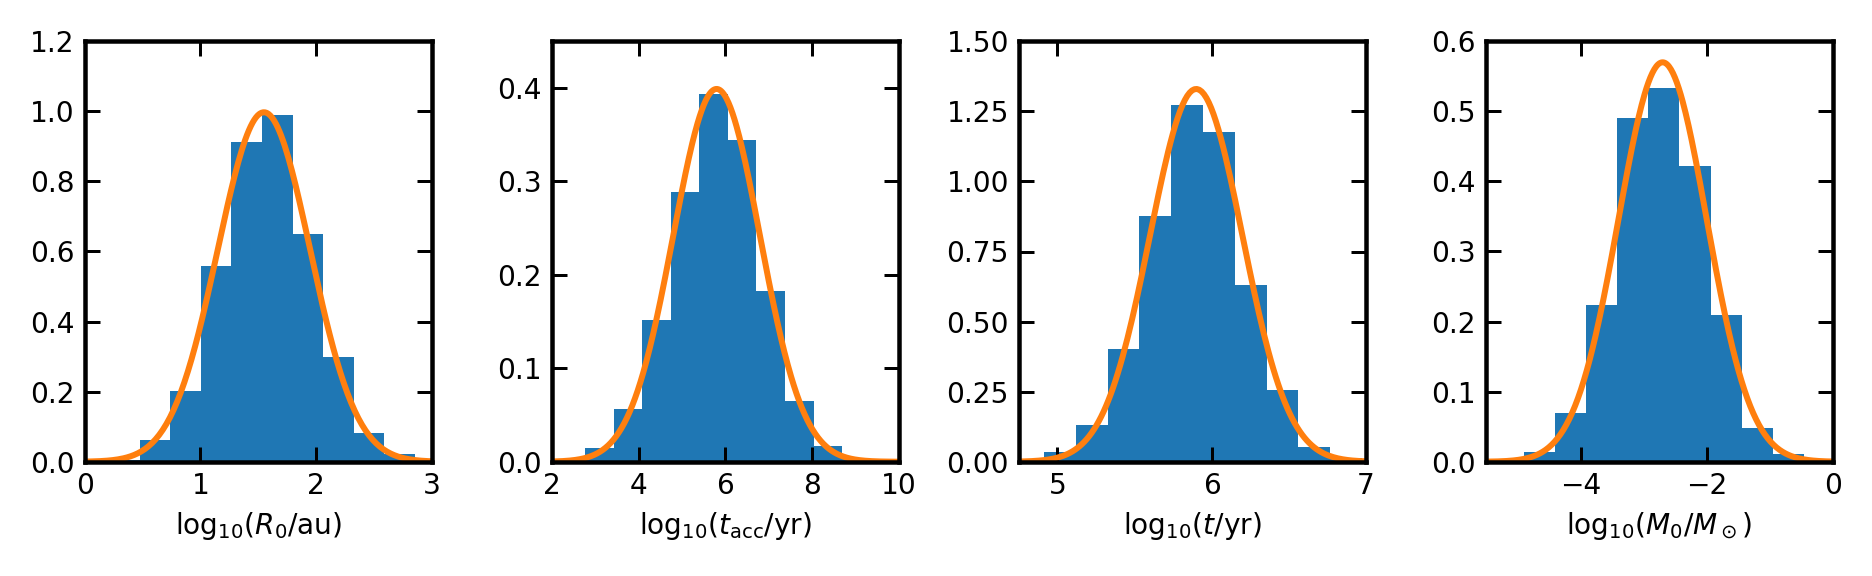

In [33]:
fig, axs = plt.subplots(1,4,figsize=(13,4))

x = np.linspace(-5.5,10,1000)

axs[0].hist(np.log10(r0),density=True)
axs[0].plot(x,gaussian(x,1.55,0.4),lw=3.)
axs[0].set_xlabel(r'$\log_{10}(R_0/{\rm au})$')
axs[0].set_xlim(0.0,3.0)
axs[0].set_ylim(0.,1.2)

axs[1].hist(np.log10(tacc),density=True)
axs[1].plot(x,gaussian(x,5.8,1.0),lw=3.)
axs[1].set_xlabel(r'$\log_{10}(t_{\rm acc}/{\rm yr})$')
axs[1].set_xlim(2,10)
axs[1].set_ylim(0.,0.45)

axs[2].hist(np.log10(time),density=True)
axs[2].plot(x,gaussian(x,5.9,0.3),lw=3.)
axs[2].set_xlabel(r'$\log_{10}(t/{\rm yr})$')
axs[2].set_xlim(4.75,7)
axs[2].set_ylim(0.,1.5)

axs[3].hist(np.log10(m0),density=True)
axs[3].plot(x,gaussian(x,-2.7,0.7),lw=3.)
axs[3].set_xlabel(r'$\log_{10}(M_0/M_\odot)$')
axs[3].set_xlim(-5.5,-0.)
axs[3].set_ylim(0.,0.6)

fig.tight_layout()
plt.show()

median alpha: -2.415301883223723
sigma alpha: 1.062067237063764


<IPython.core.display.Javascript object>


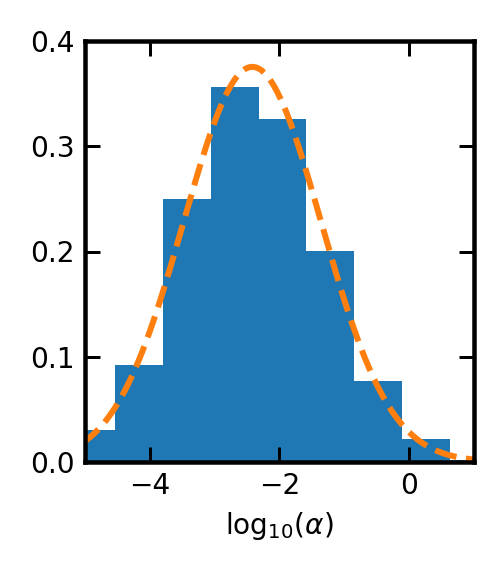

In [34]:
alpha = f_alpha(tacc,r0)

ma    = np.median(np.log10(alpha))
print('median alpha: {}'.format(ma))

sa    = np.std(np.log10(alpha))
print('sigma alpha: {}'.format(sa))

fig, axs = plt.subplots(figsize=(3.5,4))

axs.hist(np.log10(alpha),density=True)
axs.plot(x,gaussian(x,ma,sa),lw=3.,ls='--')
axs.set_xlabel(r'$\log_{10}(\alpha)$')
axs.set_xlim(-5.,1.)
axs.set_ylim(0.,0.4)

fig.tight_layout()
plt.show()

In [35]:
pars = {
    'grid': {
        'rin'  : -2.,
        'rout' :  4.,
        'nr'   : 20000,
        'gtype': 'log'
    },
    'model'    : 'visc',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

visc = disc(pars)

#Initial conditions

IC_visc = run_pop_visc(
    obj       = visc, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = np.zeros(n_dadi),
    gm        = 1.5,
    temp_args = [87.5,20.,0.5]
)

#Lupus standard configuration

lup_visc = run_pop_visc(
    obj       = visc, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = time,
    gm        = 1.5,
    temp_args = [87.5,20.,0.5]
)

#Lupus with carbon depletion

pars['xi'] = 2.50e-6
visc = disc(pars)

lup_visc_depl = run_pop_visc(
    obj       = visc, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = time,
    gm        = 1.5,
    temp_args = [87.5,20.,0.5]
)

In [36]:
pars = {
    'grid': {
        'rin'  : -3.,
        'rout' :  4.,
        'nr'   : 20000,
        'gtype': 'log'
    },
    'model'    : 'visc',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_usco,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

visc = disc(pars)

#Upper Sco standard configuration

sco_visc = run_pop_visc(
    obj       = visc, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 7.5e6*np.ones(n_dadi),
    gm        = 1.5,
    temp_args = [87.5,20.,0.5]
)

#Upper Sco with carbon depletion

pars['xi'] = 1.00e-7
visc = disc(pars)

sco_visc_depl = run_pop_visc(
    obj       = visc, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 7.5e6*np.ones(n_dadi),
    gm        = 1.5,
    temp_args = [87.5,20.,0.5]
)

<IPython.core.display.Javascript object>


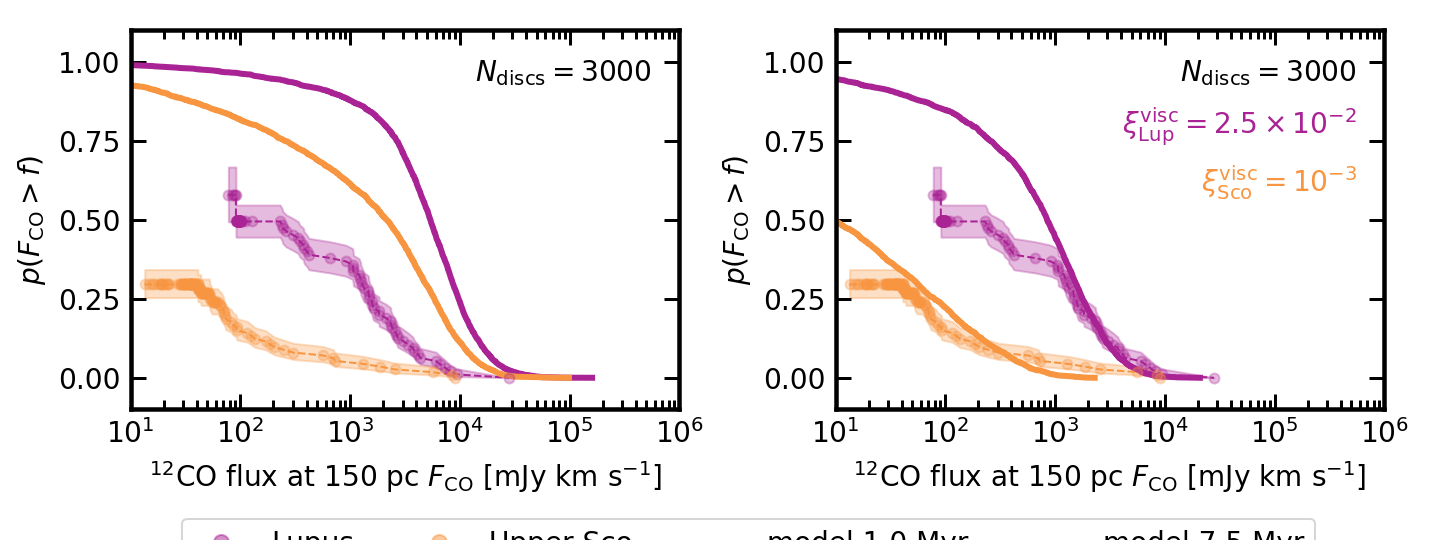

In [37]:
fig, axs = plt.subplots(1,2, figsize=(10,3.75))

cumulative(fig, axs[0])
cumulative(fig, axs[1])

axs[0].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')
axs[1].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')

axs[0].set_ylabel('$p(F_\mathrm{CO} > f)$')
axs[1].set_ylabel('$p(F_\mathrm{CO} > f)$')

# axs[0].semilogx(np.sort(IC_visc['fluxes']),np.linspace(1,0,n_dadi),lw=3,label='IC',color='k',ls='--')

axs[0].semilogx(np.sort(lup_visc['fluxes']),np.linspace(1,0,n_dadi),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
#print(np.amax(lup_visc['sizes']),np.amin(lup_visc['sizes']))
      
axs[0].semilogx(np.sort(sco_visc['fluxes']),np.linspace(1,0,n_dadi),lw=3,label='Sco',color=scalarMapi.to_rgba(interval[6]))
#print(np.amax(sco_visc['sizes']),np.amin(sco_visc['sizes']))

axs[1].semilogx(np.sort(lup_visc_depl['fluxes']),np.linspace(1,0,n_dadi),lw=3,label='Lup_depl',color=scalarMapi.to_rgba(interval[3]))
#print(np.amax(lup_visc_depl['sizes']),np.amin(lup_visc_depl['sizes']))

axs[1].semilogx(np.sort(sco_visc_depl['fluxes']),np.linspace(1,0,n_dadi),lw=3,label='Sco_depl',color=scalarMapi.to_rgba(interval[6]))
#print(np.amax(sco_visc_depl['sizes']),np.amin(sco_visc_depl['sizes']))

legend_elements = [
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[0]), label='Lupus', alpha=0.3, lw=3.),
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[2]), label='Upper Sco',alpha=0.3, lw=3.),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[3]), marker='o', label='Lupus', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[6]), marker='o', label='Upper Sco', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[3]), label=r'model 1.0 Myr', lw=3.),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[6]), label=r'model 7.5 Myr', lw=3.),
]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.520,-0.08))

axs[0].text(0.95, 0.925, r'$N_{\rm discs} = 3000$', ha='right', va='top', 
            transform=axs[0].transAxes)
axs[1].text(0.95, 0.925, r'$N_{\rm discs} = 3000$', ha='right', va='top', 
            transform=axs[1].transAxes)
axs[1].text(0.95, 0.800, r'$\xi_{\rm Lup}^{\rm visc} = 2.5\times10^{-2}$', color = scalarMapi.to_rgba(interval[3]), ha='right', va='top', 
            transform=axs[1].transAxes)
axs[1].text(0.95, 0.650, r'$\xi_{\rm Sco}^{\rm visc} = 10^{-3}$', color = scalarMapi.to_rgba(interval[6]), ha='right', va='top', 
            transform=axs[1].transAxes)

axs[0].set_xlim(1e1,1e6)
axs[1].set_xlim(1e1,1e6)

fig.tight_layout()
#plt.savefig('./paper_plots/cumulative_visc.pdf', bbox_inches='tight')

plt.show()

Compare your results with the DALI's model of Miotello at al. (2016), averaging over inclinations:

In [38]:
from scipy.interpolate import griddata

def background(axs,freq,colorbar=False):

    rc,gamma,hc,psi,mdisk,_12COJ2_1inc10,_12COJ2_1inc80,_12COJ3_2inc10,_12COJ3_2inc80 = np.loadtxt(
        './tables/tablea4.dat',skiprows=6,unpack=True,delimiter='|',usecols=(0,1,2,3,4,9,10,11,12))
    
    x, y, z = [], [], []

    for i,_rc in enumerate([30.,60.,200.]):

        for _mdisk in [1e-5,1e-4,1e-3,1e-2,1e-1]:

            flux = []
            for j,_inc in enumerate([10.,80.]):

                pars = {
                    'grid': {
                        'rin'  : 0.,
                        'rout' : 4.,
                        'nr'   : 1000,
                        'gtype': 'log'
                    },
                    'model'    : 'visc',
                    'xi'       : 1e-4,
                    'columnCO' : 5e15,
                    'freq_0'   : freq,
                    'dist'     : 100.,
                    'cos_i'    : np.cos(_inc*np.pi/180.),
                }

                visc = disc(pars)

                res  = visc.compute(init_time=0., sigma_args=[_mdisk,_rc,1,1.5], temp_args=[40.,20.,0.25])
                
                mask = np.logical_and(gamma == 1.5,np.logical_and(rc == _rc, mdisk == _mdisk))

                if _inc == 10.:
                    ff = Tb_to_Jy(np.mean(_12COJ2_1inc10[mask]), freq_0_lupo, 10.)/(res['fCO']*(freq_0_lupo/freq)**2)
                elif _inc == 80.:
                    ff = Tb_to_Jy(np.mean(_12COJ2_1inc80[mask]), freq_0_lupo, 10.)/(res['fCO']*(freq_0_lupo/freq)**2)

                if ff < 1:
                    flux.append(ff**-1)
                else:
                    flux.append(ff)

            x.append(_mdisk)
            y.append(_rc)
            z.append(np.mean(np.array(flux)))
    
    ngridx, ngridy = 500, 500

    xi = np.linspace( -5, -1, ngridx)
    yi = np.linspace(1.4,2.4, ngridy)
    
    zi = 10.**griddata((np.log10(x), np.log10(y)), np.log10(z), (xi[None,:], yi[:,None]), method='linear')

    cset = axs.contourf(xi, yi, zi, levels=np.linspace(2.,5.,200), cmap="plasma", vmin=2., vmax=5.)
    
    axs.set_rasterization_zorder(-8)
    
    cs = axs.contour(xi, yi, zi, levels=[2.,3.,4.], linewidths=2., colors='white')
    
    axs.clabel(cs, cs.levels, fontsize=16)

    for c in cset.collections:
        c.set_edgecolor("face")
    
    if colorbar:
        bar = fig.colorbar(cset, ax=axs, ticks=[1,2,3,4,5], pad=0.075)
        bar.set_label(r"DALI $F_{\rm CO}$ discrepancy factor", rotation=270, labelpad=20)

<IPython.core.display.Javascript object>


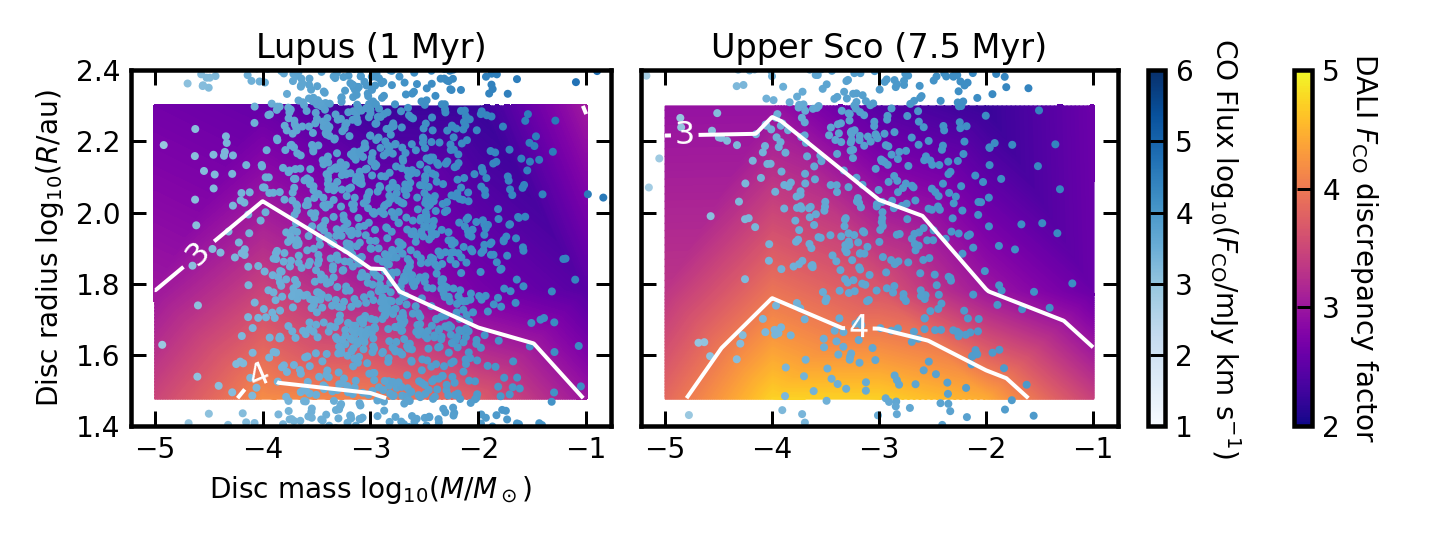

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,3.75),sharex='all',sharey='all',gridspec_kw={'width_ratios':[1,1.6]})

background(axs=axs[0],freq=freq_0_lupo)
background(axs=axs[1],freq=freq_0_usco, colorbar=True)

sca = axs[0].scatter(np.log10(lup_visc['mout']), np.log10(lup_visc['rout']), 
    c=np.log10(lup_visc['fluxes']), cmap='Blues', marker='.', vmin=1., vmax=6.)
sca = axs[1].scatter(np.log10(sco_visc['mout']), np.log10(sco_visc['rout']), 
    c=np.log10(sco_visc['fluxes']), cmap='Blues', marker='.', vmin=1., vmax=6.)
   
clb = fig.colorbar(sca, ax=axs[1])
clb.set_label(r"CO Flux $\log_{10}(F_{\rm CO}$/mJy km s$^{-1}$)", rotation=270, labelpad=25)

axs[0].set_xlim(np.log10(6e-6),np.log10(1.7e-1))
axs[0].set_ylim(1.4,2.4)

axs[0].set_xlabel(r'Disc mass $\log_{10}(M/M_\odot)$')
axs[0].set_ylabel(r'Disc radius $\log_{10}(R/{\rm au})$')

axs[0].set_title('Lupus (1 Myr)')
axs[1].set_title('Upper Sco (7.5 Myr)')

fig.tight_layout()
#plt.savefig('./paper_plots/comparison_models.pdf',bbox_inches='tight')

plt.show()

## Pops: MHD models 

Init wrapper to run populations of discs. Exclude those discs with `t > t_disp`.

In [40]:
def run_pop_wind(obj, m0, r0, tacc, t, om, lam, fm, temp_args, **kwargs):
    """ Wrapper to run populations of discs according to underlying parameter initial distributions.
        Caveat: running nested for-loops is slow and requires thousands of discs to sample the distributions properly. Avoid."""
    
    #if your r0 distribution requires unphysical small values of lambda (lam>=1.5, see Tabone et al., 2022a)
    #set lam = 1.5 (otherwise, the gas surface density increases with radius in the inner disc)
    #This is not important for standard choices of initial parameters (see later). Also, the value of lambda
    #only affect Rco when it falls in the power-law part of the surface density.
    lam[lam < 1.5] = 1.5 
    
    times, fluxes, sizes, rout, mout, mdot = [], [], [], [], [], []
    for i in range(len(m0)):
        t_disp = 2.*tacc[i]/om
        
        if t[i] <= t_disp:
        
            res = obj.compute(init_time = t[i], sigma_args = [m0[i],r0[i],tacc[i],om,lam[i]], temp_args = temp_args, fm=fm) #, freezeout=False)
            
            times.append(res['t'])
            
            sizes.append(res['rCO'])
            fluxes.append(res['fCO']*(freq_0_lupo/obj.pars['freq_0'])**2) #rescaled frequencies to account for different line transitions
            
            rout.append(res['rout'])
            mout.append(res['mout'])
            mdot.append(res['mdot'])
        
        else: continue
    
    out = {
        'times':  np.array(times),
        'fluxes': np.array(fluxes),
        'sizes':  np.array(sizes),
        'rout':   np.array(rout),
        'mout':   np.array(mout),
        'mdot':   np.array(mdot),
    }
    
    return out

Reproduce the initial timescale distribution in Tabone et al. (2022b):

<IPython.core.display.Javascript object>


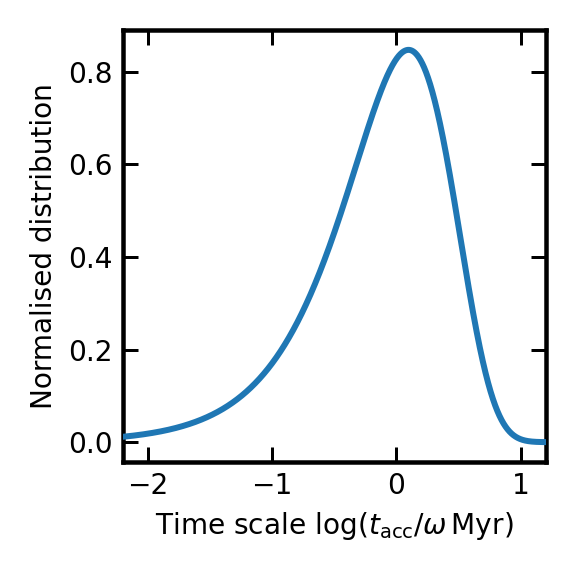

In [41]:
def ftacc(tacc0,omega=1.,tau=2.5):
    """ 
    Initial accretion timescale distribution from Tabone et al. (2022 b). 
    Parameters:
    tacc0: domain in Myr
    omega: depletion efficiency
    tau:   disc dispersal timescale
    """
    return 2.*tacc0/(tau*omega)*np.exp(-2.*tacc0/(tau*omega))*np.log(10)

fig, axs = plt.subplots(figsize=(4,4))

tacc0 = np.logspace(-4,3,10000) #Myr

axs.plot(np.log10(tacc0), ftacc(tacc0=tacc0,omega=1.), lw=3, zorder=10, c='C0')

axs.set_xlabel(r'Time scale $\log(t_\mathrm{acc}/\omega\, {\rm Myr})$')
axs.set_ylabel('Normalised distribution')

axs.set_xlim(-2.2,1.2)

fig.tight_layout()
plt.show()

Init your population of discs using the initial conditions of Tabone et al. (2022b). The effect of radial drift is that these conditions underestimate m0. R0 is not well constrained. We use the distribution of Class 0 dust disc radii of Sheehan et al. (2022):

In [42]:
def distrIC_wind(n_dadi,om):
    """ Initial conditions for the MHD-wind models from Tabone et al. (2022b). """
    
    seed_in = 125 #fix the seed to make different tests under same parameters (no substantial changes with different seeds)
    np.random.seed(seed = seed_in)
 
    print('Number of discs: {}'.format(n_dadi))

    r0   = 10.**np.random.normal(1.55, 0.4, n_dadi)
    
    if om == 1.:
        fm = 0.6

        tacc = 10.**np.random.choice(
            a       = np.log10(tacc0),
            size    = n_dadi,
            replace = True,
            p       = ftacc(tacc0=tacc0,omega=om,tau=2.5)/np.sum(ftacc(tacc0=tacc0,omega=om,tau=2.5)),
        )*1e6
        
        m0   = 10.**np.random.normal(np.log10(2e-3), 1.0, n_dadi)
        
        lam  = np.log10(r0)/(2.*np.log10(fm + 1.)) + 1. #for r_in = 1 au, from equation 4 of Tabone et al. 2022 b
        
        return r0,tacc,m0,lam,fm
    
    elif om == 0.5:
        fm = 1.8

        tacc = 10.**np.random.choice(
            a       = np.log10(tacc0),
            size    = n_dadi,
            replace = True,
            p       = ftacc(tacc0=tacc0,omega=om,tau=2.5)/np.sum(ftacc(tacc0=tacc0,omega=om,tau=2.5)),
        )*1e6
        
        m0   = 10.**np.random.normal(np.log10(4e-3), 1.0, n_dadi)
        
        lam  = np.log10(r0)/(2.*np.log10(fm + 1.)) + 1. #for r_in = 1 au, from equation 4 of Tabone et al. 2022 b

        return r0,tacc,m0,lam,fm

Case `omega = 1.0`:

In [43]:
pars = {
    'grid': {
        'rin'  : 0.,
        'rout' : 4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

#Initial conditions

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=196,om=1.)

IC_wind = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = np.zeros(196),
    om        = 1.,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

#Lupus standard configuration

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=4126,om=1.)

lup_wind = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 1.,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

Number of discs: 196
Number of discs: 4126


In [44]:
pars = {
    'grid': {
        'rin'  : -1.,
        'rout' :  4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_usco,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

#UpperSco standard configuration

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=45300,om=1.)

sco_wind = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 7.5e6*np.ones(45300),
    om        = 1.,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

Number of discs: 45300


Case `omega = 0.5`:

In [45]:
pars = {
    'grid': {
        'rin'  : -1.,
        'rout' :  4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

#Initial conditions

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=196,om=0.5)

IC_wind_05 = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = np.zeros(196),
    om        = 0.5,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

#Lupus standard configuration

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=4126,om=0.5)

lup_wind_05 = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 0.5,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

Number of discs: 196
Number of discs: 4126


In [46]:
pars = {
    'grid': {
        'rin'  : -1.,
        'rout' :  4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_usco,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

#UpperSco standard configuration

r0,tacc,m0,lam,fm = distrIC_wind(n_dadi=45300,om=0.5)

sco_wind_05 = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 7.5e6*np.ones(45300),
    om        = 0.5,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

Number of discs: 45300


<IPython.core.display.Javascript object>


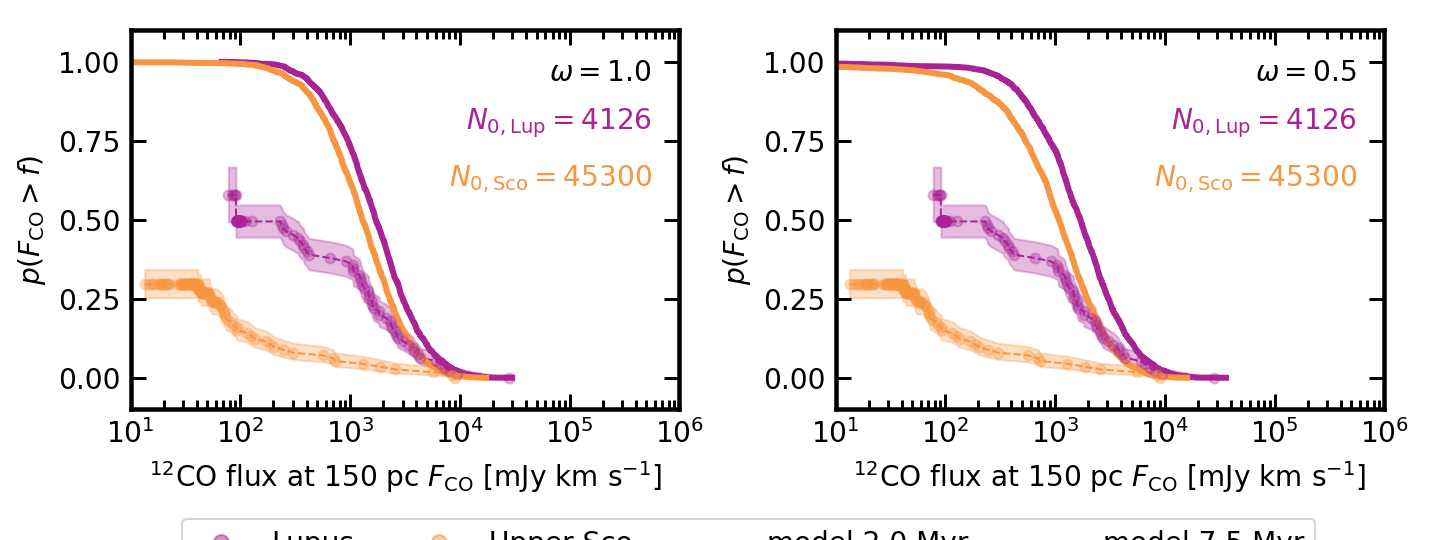

Survived discs: 1900
Survived discs: 2260


In [47]:
fig, axs = plt.subplots(1,2, figsize=(10,3.75))

cumulative(fig, axs[0])
cumulative(fig, axs[1])

axs[0].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')
axs[1].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')

axs[0].set_ylabel('$p(F_\mathrm{CO} > f)$')
axs[1].set_ylabel('$p(F_\mathrm{CO} > f)$')

#axs[0].semilogx(np.sort(IC_wind['fluxes']),np.linspace(1,0,len(IC_wind['fluxes'])),lw=3,label='IC',color='k',zorder=10,ls='--')

axs[0].semilogx(np.sort(lup_wind['fluxes']),np.linspace(1,0,len(lup_wind['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
print("Survived discs: {}".format(len(lup_wind['fluxes'][lup_wind['fluxes']>0.])))
#print(np.amax(lup_wind['sizes']),np.amin(lup_wind['sizes']))

axs[0].semilogx(np.sort(sco_wind['fluxes']),np.linspace(1,0,len(sco_wind['fluxes'])),lw=3,label='Sco',color=scalarMapi.to_rgba(interval[6]))
print("Survived discs: {}".format(len(sco_wind['fluxes'][sco_wind['fluxes']>0.])))
#print(np.amax(sco_wind['sizes']),np.amin(sco_wind['sizes']))

#axs[1].semilogx(np.sort(IC_wind_05['fluxes']),np.linspace(1,0,len(IC_wind_05['fluxes'])),lw=3,label='IC',color='k',zorder=10,ls='--')

axs[1].semilogx(np.sort(lup_wind_05['fluxes']),np.linspace(1,0,len(lup_wind_05['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
#print("Survived discs: {}".format(len(lup_wind_05['fluxes'][lup_wind_05['fluxes']>0])))
#print(np.amax(lup_wind_05['sizes']),np.amin(lup_wind_05['sizes']))

axs[1].semilogx(np.sort(sco_wind_05['fluxes']),np.linspace(1,0,len(sco_wind_05['fluxes'])),lw=3,label='Sco',color=scalarMapi.to_rgba(interval[6]))
#print("Survived discs: {}".format(len(sco_wind_05['fluxes'][sco_wind_05['fluxes']>0])))
#print(np.amax(sco_wind_05['sizes']),np.amin(sco_wind_05['sizes']))

legend_elements = [
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[3]), label='Lupus', alpha=0.3, lw=3.),
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[6]), label='Upper Sco',alpha=0.3, lw=3.),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[3]), marker='o', label='Lupus', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[6]), marker='o', label='Upper Sco', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[3]), label=r'model 2.0 Myr', lw=3.),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[6]), label=r'model 7.5 Myr', lw=3.),
]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.520,-0.08))

axs[0].text(0.95, 0.925, r'$\omega = 1.0$', ha='right', va='top', transform=axs[0].transAxes)
axs[0].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[0].transAxes)
axs[0].text(0.95, 0.650, r'$N_{\rm 0,Sco} = 45300$', ha='right', va='top', color = scalarMapi.to_rgba(interval[6]), 
            transform=axs[0].transAxes)

axs[1].text(0.95, 0.925, r'$\omega = 0.5$', ha='right', va='top', transform=axs[1].transAxes)
axs[1].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[1].transAxes)
axs[1].text(0.95, 0.650, r'$N_{\rm 0,Sco} = 45300$', ha='right', va='top', color = scalarMapi.to_rgba(interval[6]), 
            transform=axs[1].transAxes)

axs[0].set_xlim(1e1,1e6)
axs[1].set_xlim(1e1,1e6)

fig.tight_layout()
#plt.savefig('./paper_plots/cumulative_wind.pdf', bbox_inches='tight')

plt.show()

Compare our initial `R_0` distribution with those of `R_68,CO` in Lupus and `R_CO` in Upper Sco. Under the assumption that disc evolution is dominated by MHD winds, sizes do not change with time. However, Lupus shows much larger sizes than our initial `R_0` distribution. It is possible that the ICs are different between Lupus and Upper Sco, and, while in Lupus discs were born larger and substantial carbon depletion is needed, in Upper Sco they could be intrinsically smaller (Barenfeld at al., 2017; Miotello et al., 2021) with some execptions (Anderson et al., 2019). The main difference from Trapman et al. (2022) is that they do not use all detected discs but just the resolved ones missing some bright sources, hence always require depletion. 

In [48]:
dsCO, rsCO = np.loadtxt('./tables/sanchis2021.dat', skiprows=2, usecols=(2,8), unpack=True) #Table 2. of Sanchis et al. 2021 for Lupus disc sizes. We take R_68,CO. Correcting with the Gaia DR3 distance from Manara et al. (2022) does not make a difference
rbCO, mbCO, pbCO, rtCO = np.loadtxt('./tables/barenfeld2017.dat', skiprows=1, usecols=(4,5,6,7), unpack=True) #Table 2. of Barenfeld et al. (2017) for Upper Sco disc sizes. We take R_CO. For resolved discs also the values of R_90,CO of Trapman et al. (2020) are reported

<IPython.core.display.Javascript object>


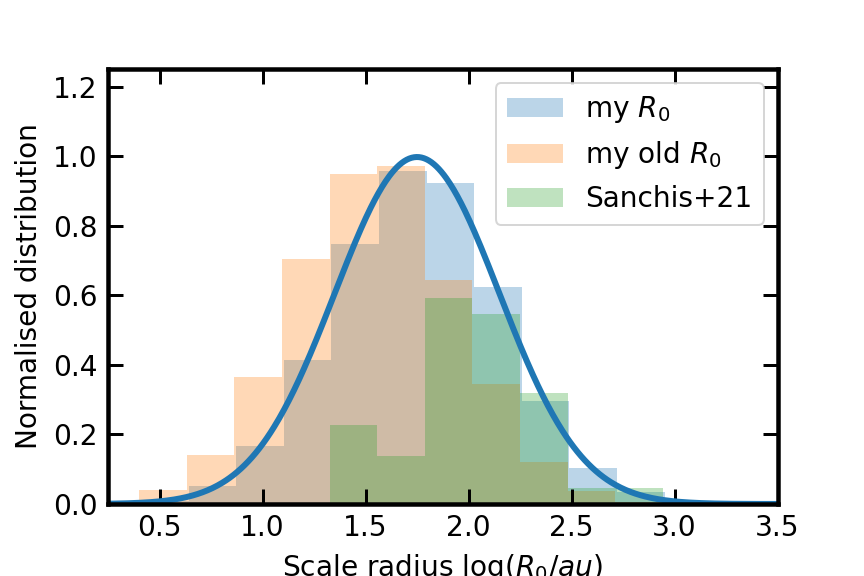

In [49]:
seed_in = 125
np.random.seed(seed = seed_in)

n_dadi  = 10000

x  = np.linspace(-2,4,1000)

r0_new = 10**np.random.normal(1.75, 0.4, n_dadi)
r0_old = 10**np.random.normal(1.55, 0.4, n_dadi)

rCO_lup = np.array(np.hstack((np.ones(95-len(dsCO)),dsCO*rsCO))) #create an array with Lupus sizes assigning 0 to unresolved discs.

fig, axs = plt.subplots()

hist = plt.hist(np.log10(r0_new),alpha=0.3,density=True,bins=12,label=r'my $R_0$')
plt.hist(np.log10(r0_old),alpha=0.3,density=True,bins=np.arange(-0.06,3,np.diff(hist[1])[0]),label=r'my old $R_0$')
plt.hist(np.log10(rCO_lup),alpha=0.3,density=True,bins=np.arange(-0.06,3,np.diff(hist[1])[0]),label=r'Sanchis+21')
plt.plot(x,gaussian(x,1.75,0.4),lw=3.,c='C0')

plt.xlabel(r'Scale radius $\log(R_0/au)$')
plt.ylabel(r'Normalised distribution')

plt.xlim(0.25,3.5)
plt.ylim(0,1.25)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


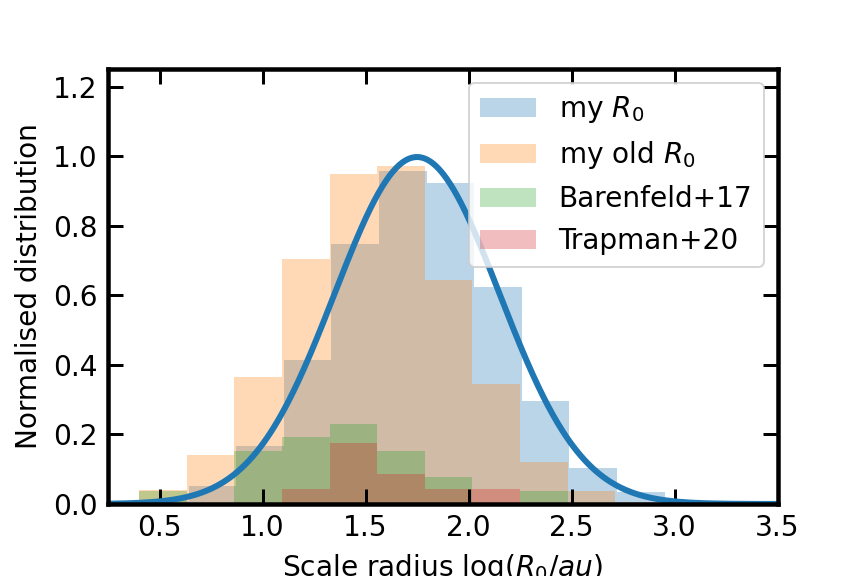

In [50]:
seed_in = 125
np.random.seed(seed = seed_in)

n_dadi  = 10000

x  = np.linspace(-2,4,1000)

r0_new = 10**np.random.normal(1.75, 0.4, n_dadi)
r0_old = 10**np.random.normal(1.55, 0.4, n_dadi)

rCO_sco  = np.array(np.hstack((np.ones(113-len(rbCO)),(rbCO)/1.62))) #1.62 scales from 95% radius to 68% radius (Sanchis et al. 2021)
rCO_scot = np.array(np.hstack((np.ones(113-len(rtCO)),(rtCO)/1.42))) #1.42 scales from 90% radius to 68% radius (Sanchis et al. 2021)

fig, axs = plt.subplots()

hist = plt.hist(np.log10(r0_new),alpha=0.3,density=True,bins=12,label=r'my $R_0$')
plt.hist(np.log10(r0_old),alpha=0.3,density=True,bins=np.arange(-0.06,3,np.diff(hist[1])[0]),label=r'my old $R_0$')
plt.hist(np.log10(rCO_sco),alpha=0.3,density=True,bins=np.arange(-0.06,3,np.diff(hist[1])[0]),label='Barenfeld+17')
plt.hist(np.log10(rCO_scot),alpha=0.3,density=True,bins=np.arange(-0.06,3,np.diff(hist[1])[0]),label='Trapman+20')
plt.plot(x,gaussian(x,1.75,0.4),lw=3.,c='C0')

plt.xlabel(r'Scale radius $\log(R_0/au)$')
plt.ylabel(r'Normalised distribution')

plt.xlim(0.25,3.5)
plt.ylim(0,1.25)

plt.legend()
plt.show()

Take home message is that Lupus discs are larger than the assumed distribution: need more carbon depletion? Test evolutionary models with Lupus new `R_0` distribution:

In [51]:
def distrIC_wind_new(n_dadi,om):
    """ Initial conditions for the MHD-wind models from Tabone et al. (2022b). """
    
    seed_in = 125 #fix the seed to make different tests under same parameters (no substantial changes with different seeds)
    np.random.seed(seed = seed_in)
 
    print('Number of discs: {}'.format(n_dadi))

    r0   = 10.**np.random.normal(1.75, 0.4, n_dadi)
    
    if om == 1.:
        fm = 0.6

        tacc = 10.**np.random.choice(
            a       = np.log10(tacc0),
            size    = n_dadi,
            replace = True,
            p       = ftacc(tacc0=tacc0,omega=om,tau=2.5)/np.sum(ftacc(tacc0=tacc0,omega=om,tau=2.5)),
        )*1e6
        
        m0   = 10.**np.random.normal(np.log10(2e-3), 1.0, n_dadi)
        
        lam  = np.log10(r0)/(2.*np.log10(fm + 1.)) + 1. #for r_in = 1 au, from equation 4 of Tabone et al. 2022 b
        
        return r0,tacc,m0,lam,fm
    
    elif om == 0.5:
        fm = 1.8

        tacc = 10.**np.random.choice(
            a       = np.log10(tacc0),
            size    = n_dadi,
            replace = True,
            p       = ftacc(tacc0=tacc0,omega=om,tau=2.5)/np.sum(ftacc(tacc0=tacc0,omega=om,tau=2.5)),
        )*1e6
        
        m0   = 10.**np.random.normal(np.log10(4e-3), 1.0, n_dadi)
        
        lam  = np.log10(r0)/(2.*np.log10(fm + 1.)) + 1. #for r_in = 1 au, from equation 4 of Tabone et al. 2022 b

        return r0,tacc,m0,lam,fm

In [52]:
pars = {
    'grid': {
        'rin'  : 0.,
        'rout' : 4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

r0,tacc,m0,lam,fm = distrIC_wind_new(n_dadi=4126,om=1.)

#Lupus standard configuration

lup_wind_R0 = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 1.,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

#Lupus with carbon depletion

pars['xi'] = 1.00e-6
wind = disc(pars)

lup_wind_R0_depl = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 1.,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.5]
)

Number of discs: 4126


In [53]:
pars = {
    'grid': {
        'rin'  : -1.,
        'rout' : 4.,
        'nr'   : 10000,
        'gtype': 'log'
    },
    'model'    : 'MHDwind',
    'xi'       : 1e-4,
    'columnCO' : 5e15,
    'freq_0'   : freq_0_lupo,
    'dist'     : 150.0,
    'cos_i'    : np.pi/4.,
}

wind = disc(pars)

r0,tacc,m0,lam,fm = distrIC_wind_new(n_dadi=4126,om=0.5)

#Lupus standard configuration

lup_wind_05_R0 = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 0.5,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.50]
)

#Lupus with carbon depletion

pars['xi'] = 1.00e-6
wind = disc(pars)

lup_wind_05_R0_depl = run_pop_wind(
    obj       = wind, 
    m0        = m0,
    r0        = r0, 
    tacc      = tacc,
    t         = 2e6*np.ones(4126),
    om        = 0.5,
    lam       = lam,
    fm        = fm,
    temp_args = [87.5,20.,0.50]
)

Number of discs: 4126


<IPython.core.display.Javascript object>


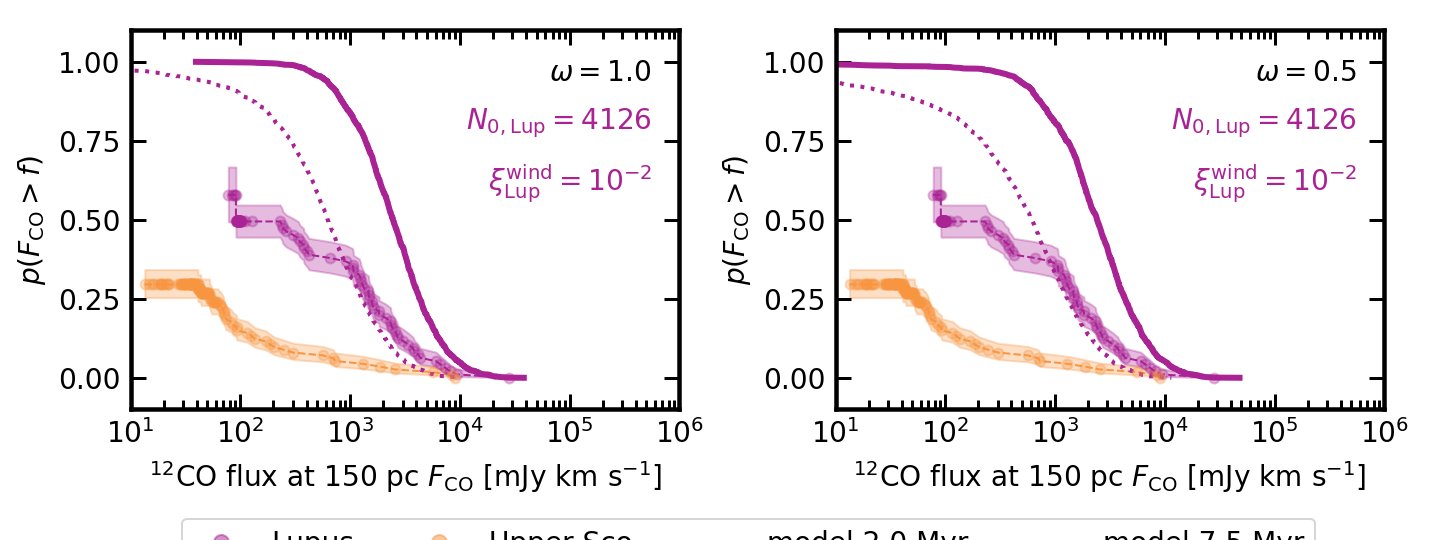

Survived discs: 1900
Survived discs: 1900


In [56]:
fig, axs = plt.subplots(1,2, figsize=(10,3.75))

cumulative(fig, axs[0])
cumulative(fig, axs[1])

axs[0].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')
axs[1].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')

axs[0].set_ylabel('$p(F_\mathrm{CO} > f)$')
axs[1].set_ylabel('$p(F_\mathrm{CO} > f)$')

axs[0].semilogx(np.sort(lup_wind_R0['fluxes']),np.linspace(1,0,len(lup_wind_R0['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
print("Survived discs: {}".format(len(lup_wind_R0['fluxes'][lup_wind_R0['fluxes']>0.])))
#print(np.amax(lup_wind_R0['sizes']),np.amin(lup_wind_R0['sizes']))

axs[0].semilogx(np.sort(lup_wind_R0_depl['fluxes']),np.linspace(1,0,len(lup_wind_R0_depl['fluxes'])),lw=2,label='Lup_depl',color=scalarMapi.to_rgba(interval[3]),ls=':')
print("Survived discs: {}".format(len(lup_wind_R0_depl['fluxes'][lup_wind_R0_depl['fluxes']>0.])))
#print(np.amax(lup_wind_R0_depl['sizes']),np.amin(lup_wind_R0_depl['sizes']))

# axs[0].semilogx(np.sort(sco_wind_depl['fluxes']),np.linspace(1,0,len(sco_wind_depl['fluxes'])),lw=2,label='Sco_depl',color=scalarMapi.to_rgba(interval[6]),ls=':')

axs[1].semilogx(np.sort(lup_wind_05_R0['fluxes']),np.linspace(1,0,len(lup_wind_05_R0['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
#print("Survived discs: {}".format(len(lup_wind_05_R0['fluxes'][lup_wind_05_R0['fluxes']>0])))
#print(np.amax(lup_wind_05_R0['sizes']),np.amin(lup_wind_05_R0['sizes']))

axs[1].semilogx(np.sort(lup_wind_05_R0_depl['fluxes']),np.linspace(1,0,len(lup_wind_05_R0_depl['fluxes'])),lw=2,label='Lup_depl',color=scalarMapi.to_rgba(interval[3]),ls=':')
#print("Survived discs: {}".format(len(lup_wind_05_R0_depl['fluxes'][lup_wind_05_R0_depl['fluxes']>0])))
#print(np.amax(lup_wind_05_R0_depl['sizes']),np.amin(lup_wind_05_R0_depl['sizes']))

# axs[1].semilogx(np.sort(sco_wind_05_depl['fluxes']),np.linspace(1,0,len(sco_wind_05_depl['fluxes'])),lw=2,label='Sco_depl',color=scalarMapi.to_rgba(interval[6]),ls=':')

legend_elements = [
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[3]), label='Lupus', alpha=0.3, lw=3.),
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[6]), label='Upper Sco',alpha=0.3, lw=3.),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[3]), marker='o', label='Lupus', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[6]), marker='o', label='Upper Sco', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[3]), label=r'model 2.0 Myr', lw=3.),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[6]), label=r'model 7.5 Myr', lw=3.),
]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.520,-0.08))

axs[0].text(0.95, 0.925, r'$\omega = 1.0$', ha='right', va='top', transform=axs[0].transAxes)
axs[0].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[0].transAxes)
#axs[0].text(0.95, 0.650, r'$N_{\rm 0,UpperSco} = 2490$', ha='right', va='top', color = scalarMapi.to_rgba(interval[6]), 
#            transform=axs[0].transAxes)
axs[0].text(0.95, 0.650, r'$\xi_{\rm Lup}^{\rm wind} = 10^{-2}$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[0].transAxes)

axs[1].text(0.95, 0.925, r'$\omega = 0.5$', ha='right', va='top', transform=axs[1].transAxes)
axs[1].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[1].transAxes)
#axs[1].text(0.95, 0.650, r'$N_{\rm 0,UpperSco} = 2490$', ha='right', va='top', color = scalarMapi.to_rgba(interval[6]), 
#            transform=axs[1].transAxes)
axs[1].text(0.95, 0.650, r'$\xi_{\rm Lup}^{\rm wind} = 10^{-2}$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[1].transAxes)

axs[0].set_xlim(1e1,1e6)
axs[1].set_xlim(1e1,1e6)

fig.tight_layout()
#plt.savefig('./paper_plots/cumulative_wind_R0.pdf', bbox_inches='tight')

plt.show()

<IPython.core.display.Javascript object>


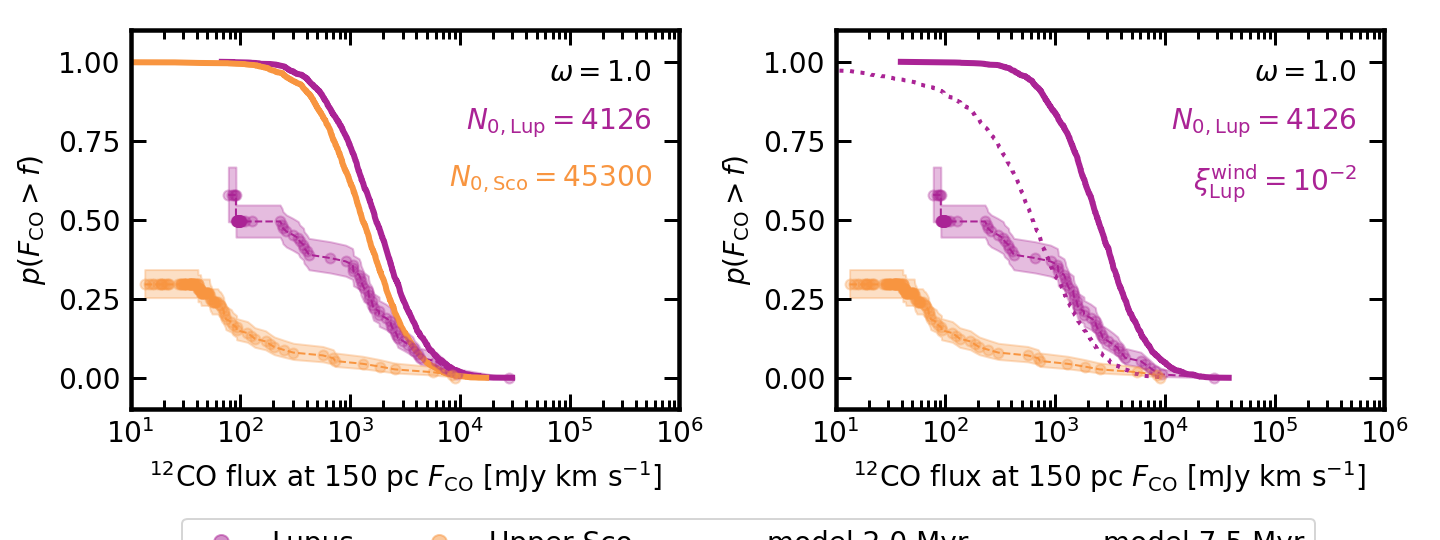

In [57]:
fig, axs = plt.subplots(1,2, figsize=(10,3.75))

cumulative(fig, axs[0])
cumulative(fig, axs[1])

axs[0].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')
axs[1].set_xlabel(r'$^{12}$CO flux at 150 pc $F_\mathrm{CO}$ [mJy km s$^{-1}$]')

axs[0].set_ylabel('$p(F_\mathrm{CO} > f)$')
axs[1].set_ylabel('$p(F_\mathrm{CO} > f)$')

#axs[0].semilogx(np.sort(IC_wind['fluxes']),np.linspace(1,0,len(IC_wind['fluxes'])),lw=3,label='IC',color='k',zorder=10,ls='--')

axs[0].semilogx(np.sort(lup_wind['fluxes']),np.linspace(1,0,len(lup_wind['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
#print("Survived discs: {}".format(len(lup_wind['fluxes'][lup_wind['fluxes']>0.])))
#print(np.amax(lup_wind['sizes']),np.amin(lup_wind['sizes']))

axs[0].semilogx(np.sort(sco_wind['fluxes']),np.linspace(1,0,len(sco_wind['fluxes'])),lw=3,label='Sco',color=scalarMapi.to_rgba(interval[6]))
#print("Survived discs: {}".format(len(sco_wind['fluxes'][sco_wind['fluxes']>0.])))
#print(np.amax(sco_wind['sizes']),np.amin(sco_wind['sizes']))

#axs[1].semilogx(np.sort(IC_wind_R0['fluxes']),np.linspace(1,0,len(IC_wind_R0['fluxes'])),lw=3,label='IC_depl',color='k',zorder=10,ls='--')

axs[1].semilogx(np.sort(lup_wind_R0['fluxes']),np.linspace(1,0,len(lup_wind_R0['fluxes'])),lw=3,label='Lup',color=scalarMapi.to_rgba(interval[3]))
#print("Survived discs: {}".format(len(lup_wind_R0['fluxes'][lup_wind_R0['fluxes']>0.])))
#print(np.amax(lup_wind_R0['sizes']),np.amin(lup_wind_R0['sizes']))

axs[1].semilogx(np.sort(lup_wind_R0_depl['fluxes']),np.linspace(1,0,len(lup_wind_R0_depl['fluxes'])),lw=2,label='Lup_depl',color=scalarMapi.to_rgba(interval[3]),ls=':')
#print("Survived discs: {}".format(len(lup_wind_R0_depl['fluxes'][lup_wind_R0_depl['fluxes']>0.])))
#print(np.amax(lup_wind_R0_depl['sizes']),np.amin(lup_wind_R0_depl['sizes']))

legend_elements = [
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[3]), label='Lupus', alpha=0.3, lw=3.),
    #mpatches.Patch(color=scalarMapi.to_rgba(interval[6]), label='Upper Sco',alpha=0.3, lw=3.),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[3]), marker='o', label='Lupus', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='--', color=scalarMapi.to_rgba(interval[6]), marker='o', label='Upper Sco', ms=7.5, lw=1.5, alpha=0.5),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[3]), label=r'model 2.0 Myr', lw=3.),
    #Line2D([0], [0], ls=':', color=scalarMapi.to_rgba(interval[3]), label=r'model 2.0 Myr (depleted)', lw=3.),
    Line2D([0], [0], ls='-', color=scalarMapi.to_rgba(interval[6]), label=r'model 7.5 Myr', lw=3.),
]

lgd = plt.figlegend(handles=legend_elements, ncol=4, loc = 'lower center', bbox_to_anchor=(0.520,-0.08))

axs[0].text(0.95, 0.925, r'$\omega = 1.0$', ha='right', va='top', transform=axs[0].transAxes)
axs[0].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[0].transAxes)
axs[0].text(0.95, 0.650, r'$N_{\rm 0,Sco} = 45300$', ha='right', va='top', color = scalarMapi.to_rgba(interval[6]), 
            transform=axs[0].transAxes)

axs[1].text(0.95, 0.925, r'$\omega = 1.0$', ha='right', va='top', transform=axs[1].transAxes)
axs[1].text(0.95, 0.800, r'$N_{\rm 0,Lup} = 4126$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[1].transAxes)
axs[1].text(0.95, 0.650, r'$\xi_{\rm Lup}^{\rm wind} = 10^{-2}$', ha='right', va='top', color = scalarMapi.to_rgba(interval[3]), 
            transform=axs[1].transAxes)

axs[0].set_xlim(1e1,1e6)
axs[1].set_xlim(1e1,1e6)

fig.tight_layout()
#plt.savefig('./paper_plots/cumulative_wind_final_newtemp.pdf', bbox_inches='tight')

plt.show()

### Size-luminosity correlation

In [58]:
name, tlCO, flCO, rlCO, elCO, dlCO = np.loadtxt('./tables/long2022.dat',skiprows=7,unpack=True,usecols=(0,8,9,10,11,14)) #Table 2 of Long et al. (2022)

nlCO = freq_0_lupo*np.ones(len(name))
nlCO[tlCO==32] = freq_0_usco

In [59]:
print(name[0],tlCO[0],nlCO[0]/1e9,flCO[0],rlCO[0],elCO[0],dlCO[0])
flux_long = flCO*(dlCO/140.)**2*(freq_0_lupo/nlCO)**2

1.0 21.0 230.538 1.94 115.0 13.0 128.0


<IPython.core.display.Javascript object>


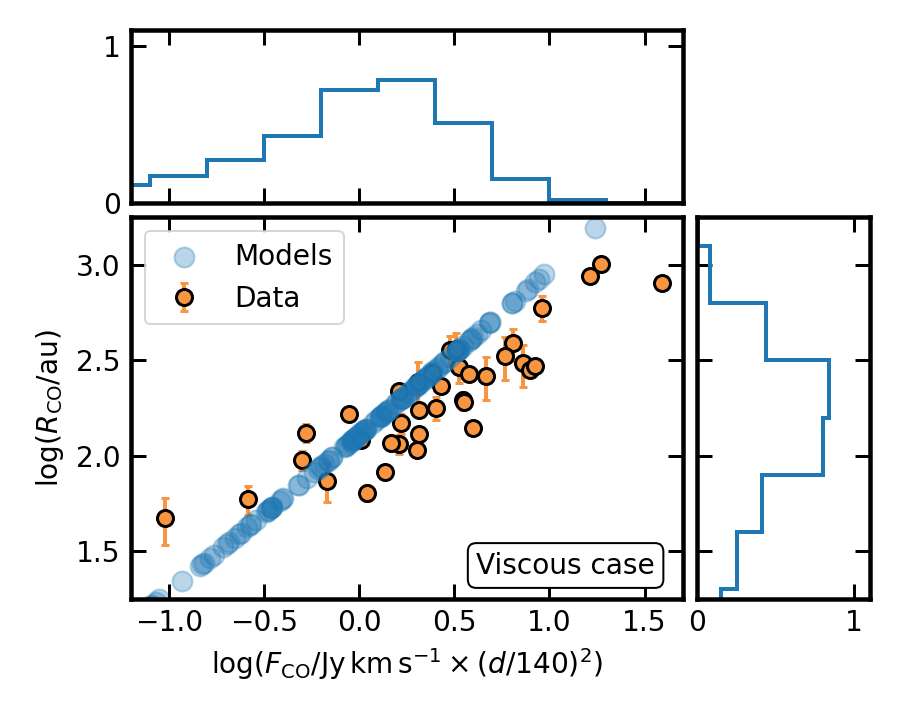

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(6.25,5.))

axs.errorbar(np.log10(flux_long), np.log10(rlCO), yerr = [np.log10(rlCO)-np.log10(rlCO-elCO),np.log10(rlCO+elCO)-np.log10(rlCO)], color = scalarMapi.to_rgba(interval[6]), lw = 2., ls = 'none', marker = 'o', ms = 8., mew = 1.5, mec = 'k', capsize = 2., capthick = 2., label = 'Data', zorder = -10)

axs.scatter(np.log10(lup_visc_depl['fluxes']*(150./140.)**2*1e-3)[::20], np.log10(lup_visc_depl['sizes'])[::20], label='Models', s=100., marker='o', color='C0', alpha=0.3)

axs.text(0.95, 0.05, r'Viscous case', ha='right', va='bottom', transform=axs.transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))

axs.set_xlim(-1.2,1.7)
axs.set_ylim(1.25,3.25)

axs.set_ylabel(r'$\log(R_{\rm CO}/{\rm au})$')
axs.set_xlabel(r'$\log(F_{\rm CO}/{\rm Jy}\, {\rm km}\, {\rm s}^{-1} \times (d/140)^2)$')

axs.legend(loc='upper left')

divider = make_axes_locatable(axs)

axs_histx = divider.append_axes("top",   1.2, pad=0.1, sharex=axs)
axs_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=axs)

axs_histx.yaxis.set_ticks([0.,1.])

axs_histx.xaxis.set_tick_params(labelbottom=False)
axs_histy.yaxis.set_tick_params(labelleft=False)

bins_ref = np.arange(-2.,5.,0.3)

#_,bins,_ = axs_histx.hist(np.log10(flux_long[flux_long>0]),bins=12,density=True,histtype='step',lw=2,color=scalarMapi.to_rgba(interval[6]))
axs_histx.hist(np.log10(lup_visc_depl['fluxes']*(150./140.)**2*1e-3),density=True,bins=bins_ref,histtype='step',lw=2)
#_,bins,_ = axs_histy.hist(np.log10(rlCO),bins=7,density=True,orientation='horizontal',histtype='step',lw=2,color=scalarMapi.to_rgba(interval[6]))
axs_histy.hist(np.log10(lup_visc_depl['sizes']),density=True,orientation='horizontal',bins=bins_ref,histtype='step',lw=2)

axs_histx.set_ylim(0,1.1)
axs_histy.set_xlim(0,1.1)

fig.tight_layout()
#plt.savefig('./paper_plots/SL_correlation_visc.pdf',bbox_inches='tight')

plt.show()

<IPython.core.display.Javascript object>


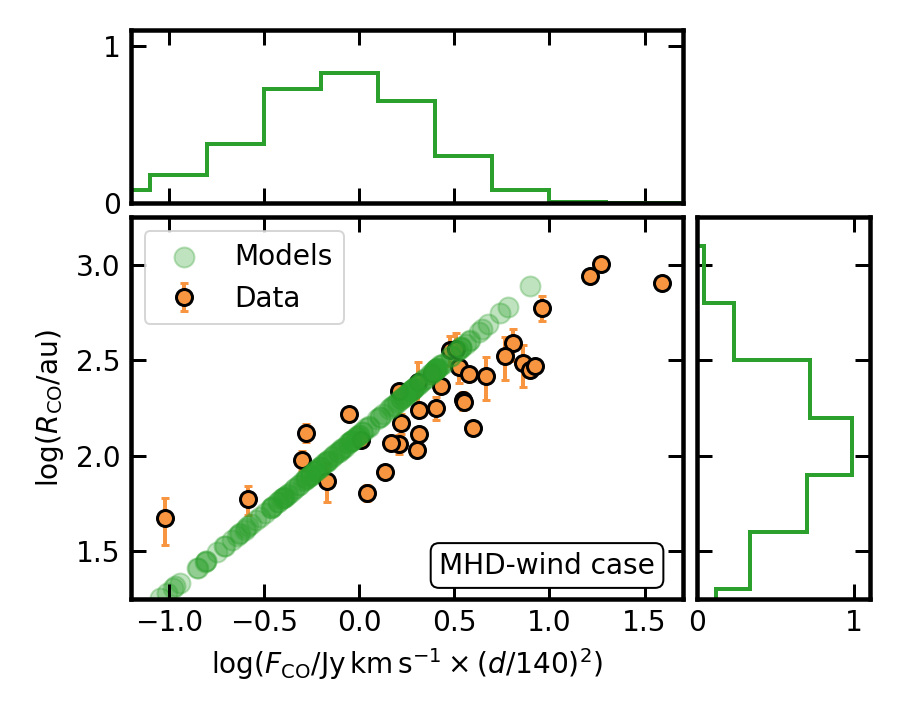

In [61]:
fig, axs = plt.subplots(figsize=(6.25,5.))

axs.errorbar(np.log10(flux_long), np.log10(rlCO), yerr = [np.log10(rlCO)-np.log10(rlCO-elCO),np.log10(rlCO+elCO)-np.log10(rlCO)], color = scalarMapi.to_rgba(interval[6]), lw = 2., ls = 'none', marker = 'o', ms = 8., mew = 1.5, mec = 'k', capsize = 2., capthick = 2., label = 'Data', zorder = -10)

axs.scatter(np.log10(lup_wind_R0_depl['fluxes']*(150./140.)**2*1e-3)[::12], np.log10(lup_wind_R0_depl['sizes'])[::12],label = 'Models', s = 100., marker = 'o', color = 'C2', alpha = 0.3)

axs.text(0.95, 0.05, r'MHD-wind case', ha='right', va='bottom', transform=axs.transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))

axs.set_xlim(-1.2,1.7)
axs.set_ylim(1.25,3.25)

axs.set_ylabel(r'$\log(R_{\rm CO}/{\rm au})$')
axs.set_xlabel(r'$\log(F_{\rm CO}/{\rm Jy}\, {\rm km}\, {\rm s}^{-1} \times (d/140)^2)$')

axs.legend(loc='upper left')

divider = make_axes_locatable(axs)

axs_histx = divider.append_axes("top",   1.2, pad=0.1, sharex=axs)
axs_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=axs)

axs_histx.yaxis.set_ticks([0.,1.])

axs_histx.xaxis.set_tick_params(labelbottom=False)
axs_histy.yaxis.set_tick_params(labelleft=False)

bins_ref = np.arange(-2.,5.,0.30)

#_,bins,_ = axs_histx.hist(np.log10(flux_long[flux_long>0]),bins=12,density=True,histtype='step',lw=2,color=scalarMapi.to_rgba(interval[6]))
axs_histx.hist(np.log10(lup_wind_R0_depl['fluxes']*(150./140.)**2*1e-3),density=True,bins=bins_ref,histtype='step',lw=2,color='C2')
#_,bins,_ = axs_histy.hist(np.log10(rlCO),bins=7,density=True,orientation='horizontal',histtype='step',lw=2,color=scalarMapi.to_rgba(interval[6]))
axs_histy.hist(np.log10(lup_wind_R0_depl['sizes']),density=True,orientation='horizontal',bins=bins_ref,histtype='step',lw=2,color='C2')

axs_histx.set_ylim(0,1.1)
axs_histy.set_xlim(0,1.1)

fig.tight_layout()
#plt.savefig('./paper_plots/SL_correlation_wind.pdf',bbox_inches='tight')

plt.show()